#                                      ====== Stroke Prediction Model ======


# 1. Introduction

Pada Notebook ini saya akan mencoba untuk membuat prediksi apakah seseorang dengan kondisi kesehatan tertentu mengidap stroke atau tidak. Ini adalah project kedua saya dalam mencoba model klasifikasi. Notebook ini akan dibagi menjadi beberapa bagian :
1. Introduction
2. Data Preprocessing
3. Modeling
4. Model Tuning
5. Deployment
6. Conclusion



Berdasarkan wikipedia stroke adalah kondisi kesehatan dimana alirah darah ke otak melemah dan menyebabkan sel - sel pada otak mati (wikipedia.com). Sayangnya, tidak ada obat saat ini untuk menyembuhkan struk. Tapi menurut dokter dan ahli kesehatan mereka sepakat bahwa pencegahan dapat dilakukan dengan mengidentifikasi gejala - gejala stroke dini yang dimiliki seseorang. Dengan bantuan machine learning saya aka mencoba membuat model terbaik dari dataset dengan 5110 pasien dengan 10 kondisi kesehatan yang berbeda - beda untuk memprediksi kemungkinan Stroke pada seseorang berdasarkan kondisi kesehatan yang dimiliki.

In [1]:
# import basic library
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import date
from scipy import stats

#Fetaure Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Model Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
import scikitplot as skplt

#Modelling Algoritm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Deployment
import pickle

In [2]:
# Load dataset
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
# Melihat info dari dataset seperti jumlah kolom, input, type data, dan memori
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [5]:
# Melihat apakah ada missing value dalam dataset
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Sebagian besar dataset kita tidak ada missing value, namun perlu kita cek satu persatu kolom apakah ada miss interpretasi atau salah input.

# 2. Data Preprocessing

## 2.1 Handling Variabel

Pada bagian ini kita akan melakukan penanganan pada tiap variabel atau kolom pada dataset, seperti handling missing value, melihat distribusi pada tiap kolom, dan EDA pada tiap kolom

count    5110.000000
mean       43.226614
std        22.612731
min         0.000000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64


Text(0.5, 1.0, 'Age Distribution')

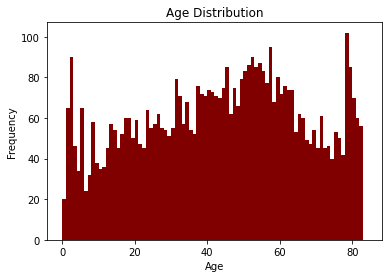

In [6]:
# Karena type data age adalah float tapi tidak memungkinkan umur berbentuk desimal,
# maka kita akan mengubah menjadi integer dengan pembulatan
data.age = data.age.round().astype('int')
print(data.age.describe())
# melihat distribusi kolom age
bin_list = list(range(0,85,1))
plt.hist(x=data.age,bins=bin_list,color='maroon')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

No     4612
Yes     498
Name: hypertension, dtype: int64


Text(0, 0.5, 'Frequency')

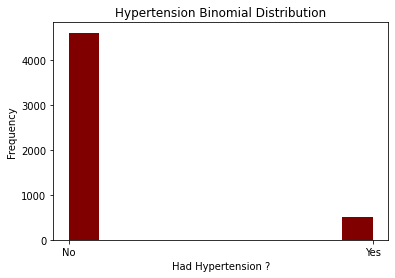

In [7]:
# kolom Hypertension merupakan kolom kategori yang berisi True or False value, True = 1, False = 0
hypertension = data.hypertension.replace({0:'No',1:'Yes'})
print(hypertension.value_counts())
plt.hist(x= hypertension,color='maroon')
plt.title('Hypertension Binomial Distribution')
plt.xlabel('Had Hypertension ?')
plt.ylabel('Frequency')

No     4834
Yes     276
Name: heart_disease, dtype: int64


Text(0, 0.5, 'Frequency')

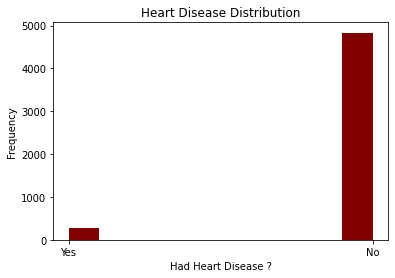

In [8]:
# kolom heart_disease juga kolom kategori, kita akan mengganti 0 = No dan 1 = Yes
heart_disease = data.heart_disease.replace({0:'No',1:'Yes'})
print(heart_disease.value_counts())
plt.hist(x=heart_disease,color='maroon')
plt.title('Heart Disease Distribution')
plt.xlabel('Had Heart Disease ?')
plt.ylabel('Frequency')

In [9]:
# dari grafik di atas dapat dilihat bahwa kolom hypertension dan heart_disease
# memiliki hubungan, kita akan membandingkan kedua kolom tersebut
compare = pd.DataFrame()
compare = data.loc[(data['hypertension'] != data['heart_disease'])]
compare

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
10,12109,Female,81,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
11,12095,Female,61,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5088,22190,Female,64,1,0,Yes,Self-employed,Urban,76.89,30.2,Unknown,0
5091,6369,Male,59,1,0,Yes,Private,Rural,95.05,30.9,never smoked,0
5093,32235,Female,45,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5100,68398,Male,82,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0


dari perbandingan di atas terdapat 646 pasien yang kondisi hipertensi dan heart disease nya berlawanan satu sama lain (apabila pasien mengidap hipertensi pasien tersebut tidak mengidap heart disease). sebagain besar pasien (4464 pasien) memiliki kondisi hupertensi dan heart disease yang searah (apabila pasien mengidap hipertensi pasien tersebut mengidap heart disease juga).
Maka dapat kita simpulkan bahwa korelasi antara hipertensi dan heart disease positif atau searah.

Yes    3353
No     1757
Name: ever_married, dtype: int64


Text(0, 0.5, 'Frequency')

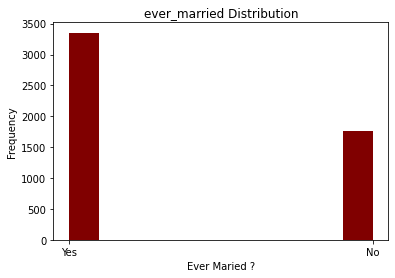

In [10]:
# kolom ever_married juga merupakan kolom kategori,
# kita ingin melihat distribusi pada kolom ini
print(data.ever_married.value_counts())
plt.hist(data.ever_married,color='maroon')
plt.title('ever_married Distribution')
plt.xlabel('Ever Maried ?')
plt.ylabel('Frequency')

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Text(0.5, 0, 'Type of Work')

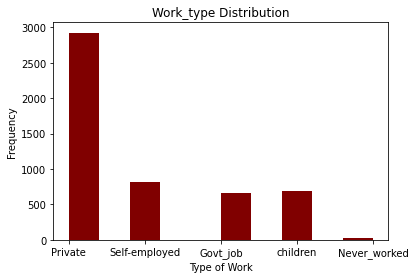

In [11]:
# kolom work_type juga merupakan kolom kategori
# kita akan melihat ada berapa kategori dalam kolom tersebut
print(data.work_type.value_counts())
# ada 5 kategori dalam kolom work_type, nanti akan kita ubah menjadi label untuk analisa
plt.hist(x= data.work_type,color='maroon')
plt.title('Work_type Distribution')
plt.ylabel('Frequency')
plt.xlabel('Type of Work')

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


Text(0, 0.5, 'Frequency')

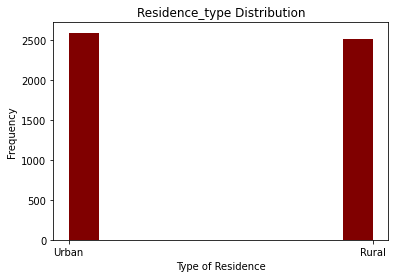

In [12]:
# kolom Residence_type juga merupakan kolom kategori
# kita ingin melihat distribusi dari value 
print(data.Residence_type.value_counts())
plt.hist(x=data.Residence_type,color='maroon')
plt.title('Residence_type Distribution')
plt.xlabel('Type of Residence')
plt.ylabel('Frequency')

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64


Text(0.5, 0, 'Avg Glucose Level')

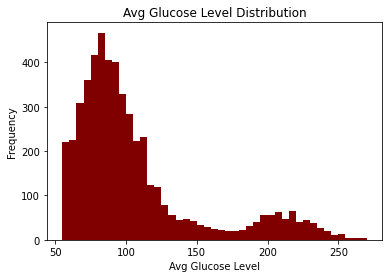

In [13]:
# kolom avg_glucose_level bertipe float sudah sesuai
# melihat EDA dari kolom
print(data.avg_glucose_level.describe())

# melihat distribusi dari kolom
bins_list = list(range(55,275,5))
plt.hist(x=data.avg_glucose_level, bins=bins_list,color='maroon')
plt.title('Avg Glucose Level Distribution')
plt.ylabel('Frequency')
plt.xlabel('Avg Glucose Level')

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64


Text(0, 0.5, 'Frequency')

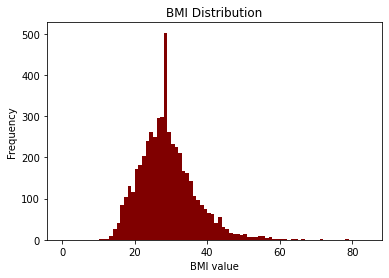

In [14]:
# kolom bmi bertipe float juga, terdapat missing value pada kolom
# melihat EDA dari kolom bmi
print(data.bmi.describe())
# mengisi missing value dengan mean dari kolom bmi
data.bmi = data.bmi.fillna(data.bmi.mean())
# melihat distribusi dari kolom bmi
plt.hist(data.bmi, bins=bin_list,color='maroon')
bin_list=list(range(10,100,1))
plt.title('BMI Distribution')
plt.xlabel('BMI value')
plt.ylabel('Frequency')

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


Text(0.5, 0, 'Smoking Status')

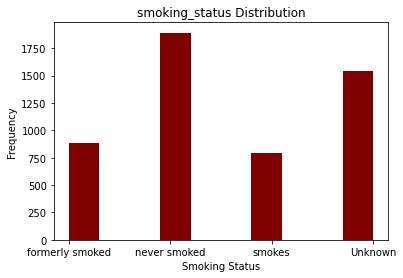

In [15]:
# kolom smoking_status adalah kategori
# melihat unique value dari kolom smoking_status
print(data.smoking_status.value_counts())
plt.hist(data.smoking_status,histtype='barstacked',color='maroon')
plt.title('smoking_status Distribution')
plt.ylabel('Frequency')
plt.xlabel('Smoking Status')


No     4861
Yes     249
Name: stroke, dtype: int64


Text(0, 0.5, 'Stroke')

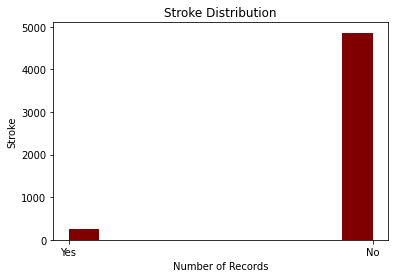

In [16]:
# kolom stroke merupakan kolom target yang akan kita prediksi
# melihat distribusi value kolom stroke
stroke = data.stroke.replace({0:'No',1:'Yes'})
print(stroke.value_counts())
# data imblance karena nilai 0 atau tidak stroke jauh lebih besar dari nilai 1 atau stroke
plt.hist(x=stroke,color='maroon')
plt.title('Stroke Distribution')
plt.xlabel('Number of Records')
plt.ylabel('Stroke')

In [17]:
# melihat apakah masih ada missing values
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Setelah di cek satu persatu kolom dataset kita sudah bersih dari missing value dan tidak ada salah input atau miss interpretasi

## 2.2 Data Exploration

Pada bagian ini kita akan melakukan ekslorasi pada dataset, kolom - kolom, dan visualisasi insight yang ada pada dataset ini.

### 2.2.1 Hypertension

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


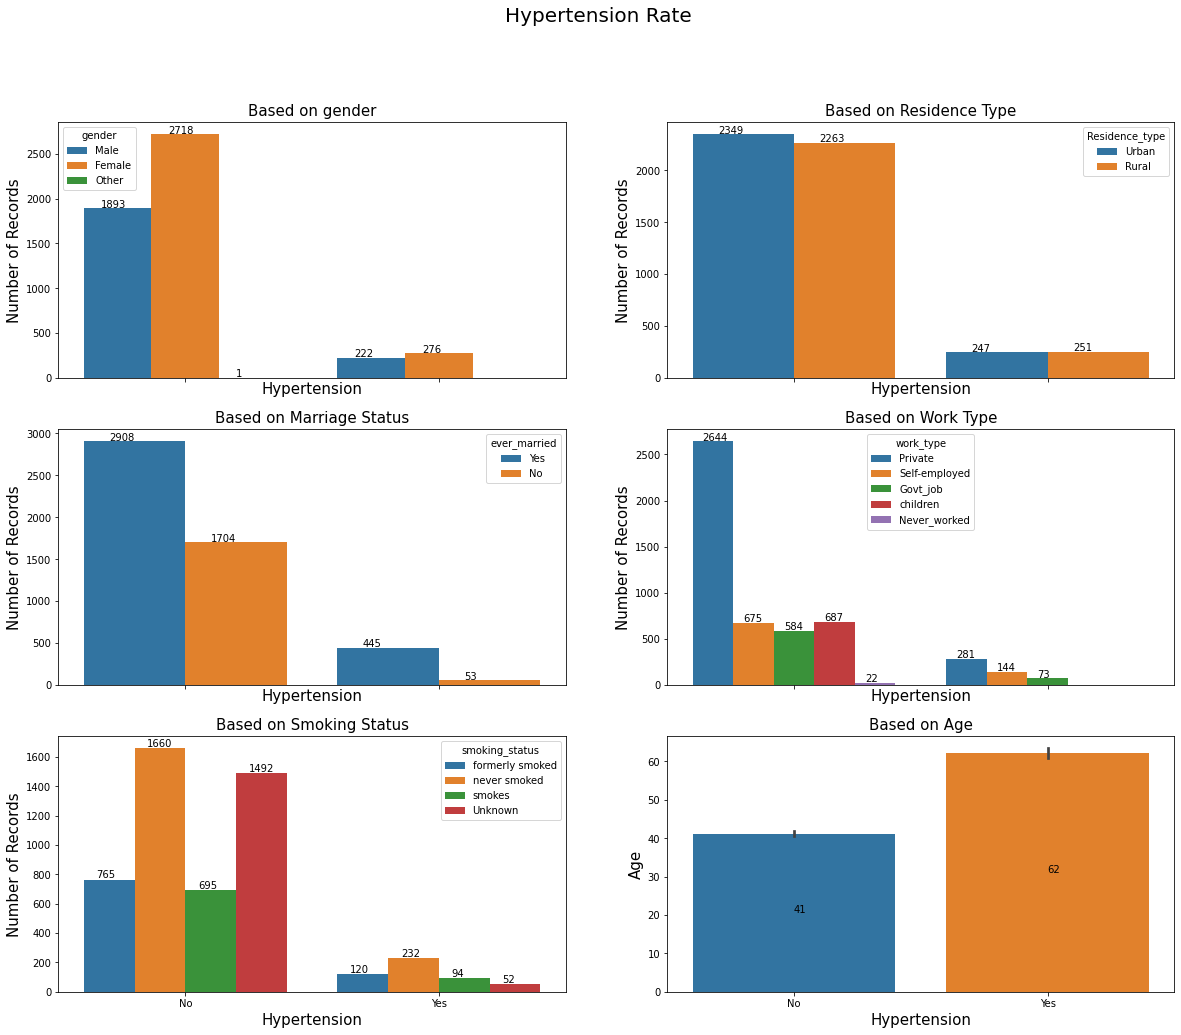

In [18]:
# kita akan mencari insight dari data hipertensi terhadap kolom kolom lain di data set ini
# pertama saya akan duplikat dataset agar dataset original tidak terganggu
data_vis = data.copy()
data_vis.hypertension = data_vis.hypertension.replace({0:'No',1:'Yes'})

# membuat figure dari 6 plot 
fig, axes = plt.subplots(3, 2, figsize=(20,16), sharey=False,sharex=True)
fig.suptitle('Hypertension Rate',fontsize=20)

# Hypertension Based on Gender
sns.countplot(ax=axes[0,0], data=data_vis, x='hypertension', hue='gender',)
axes[0,0].set_title('Based on gender',fontsize=15)
axes[0,0].set_xlabel('Hypertension',fontsize=15)
axes[0,0].set_ylabel('Number of Records',fontsize=15)
for i in axes[0,0].patches:
   axes[0,0].text(i.get_x() + i.get_width()/4, i.get_height() + 10, "%.0f" % i.get_height())

# Hypertension Based on Residence Type
sns.countplot(ax=axes[0,1], data=data_vis,x='hypertension',hue='Residence_type')
axes[0,1].set_title('Based on Residence Type',fontsize=15)
axes[0,1].set_xlabel('Hypertension',fontsize=15)
axes[0,1].set_ylabel('Number of Records',fontsize=15)
for  x in axes[0,1].patches:
   axes[0,1].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# Hypertension Based on Marriage Status
sns.countplot(ax=axes[1,0], data=data_vis,x='hypertension',hue='ever_married')
axes[1,0].set_title('Based on Marriage Status',fontsize=15)
axes[1,0].set_xlabel('Hypertension',fontsize=15)
axes[1,0].set_ylabel('Number of Records',fontsize=15)
for  x in axes[1,0].patches:
   axes[1,0].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# Hypertension Based on Work Type
sns.countplot(ax=axes[1,1], data=data_vis,x='hypertension',hue='work_type')
axes[1,1].set_title('Based on Work Type',fontsize=15)
axes[1,1].set_xlabel('Hypertension',fontsize=15)
axes[1,1].set_ylabel('Number of Records',fontsize=15)
for  x in axes[1,1].patches:
   axes[1,1].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# Hypertension Based on Smoking Status
sns.countplot(ax=axes[2,0], data=data_vis,x='hypertension',hue='smoking_status')
axes[2,0].set_title('Based on Smoking Status',fontsize=15)
axes[2,0].set_xlabel('Hypertension',fontsize=15)
axes[2,0].set_ylabel('Number of Records',fontsize=15)
for  x in axes[2,0].patches:
   axes[2,0].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# Hypertensi Based on age
sns.barplot(data=data_vis,y='age',x='hypertension',ax=axes[2,1])
axes[2,1].set_title('Based on Age',fontsize=15)
axes[2,1].set_xlabel('Hypertension',fontsize=15)
axes[2,1].set_ylabel('Age',fontsize=15)
for  x in axes[2,1].patches:
   axes[2,1].text( x.get_x() +  x.get_width()/2,  x.get_height()/2, "%.0f" % x.get_height())



Dari Grafik Hypertension Rate di atas dapat disimpulkan bahwa :
1. lebih banyak pasien yang tidak memiliki hipertensi daripada yang memiliki (imbalance).
2. berdasarkan gender presentase female lebih banyak dari pada male dalam kondisi memiliki hipertensi maupun tidak.
3. berdasarkan residence type pasien yang tinggal di rural area memiliki potensi mengidap hipertensi lebih besar. 
4. berdasarkan status pernikahan pasien yang pernah menikah memiliki potensi  mengidap hipertensi lebih besar 
5. berdasrkan tipe pekerjaan pasien yang bekerja di sektor swasta (private) memiliki potensi mengidap hipertensi lebih besar
6. berdasarkan kondisi merokok, pasien yang tidak pernah merokok memiliki potensi mengidap hipertensi yang lebih besar.
7. berdasarkan kondisi umur, pasien dengan umur di atas 41 tahun memiliki potensi mengidap hipertensi lebih besar.


### 2.2.2 Heart Disease

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


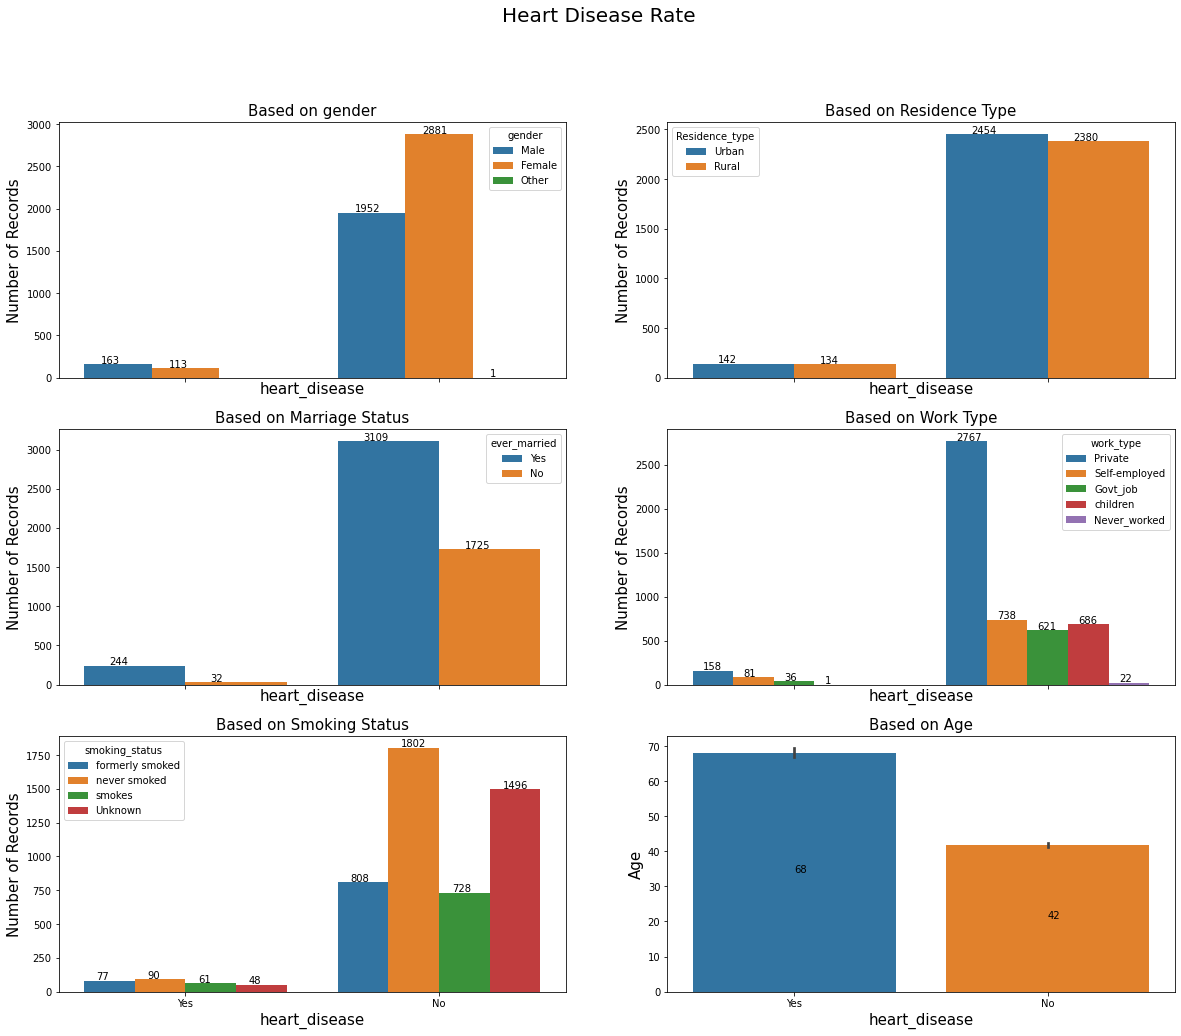

In [19]:
# kita akan mencari insight dari kolom heart disease terhadap kolom kolom lain di data set ini
# agar lebih mudah dipahami saya akan mengganti nilai 0 menjadi No 
# dan 1 menjadi Yes pada kolom heart disease
data_vis.heart_disease = data_vis.heart_disease.replace({0:'No',1:'Yes'})

# membuat figure dengan 6 plot
fig, axes = plt.subplots(3, 2, figsize=(20,16), sharey=False,sharex=True)
fig.suptitle('Heart Disease Rate',fontsize=20)

# heart_disease Based on Gender
sns.countplot(ax=axes[0,0], data=data_vis, x='heart_disease', hue='gender',)
axes[0,0].set_title('Based on gender',fontsize=15)
axes[0,0].set_xlabel('heart_disease',fontsize=15)
axes[0,0].set_ylabel('Number of Records',fontsize=15)
for i in axes[0,0].patches:
   axes[0,0].text(i.get_x() + i.get_width()/4, i.get_height() + 10, "%.0f" % i.get_height())

# heart_disease Based on Residence Type
sns.countplot(ax=axes[0,1], data=data_vis,x='heart_disease',hue='Residence_type')
axes[0,1].set_title('Based on Residence Type',fontsize=15)
axes[0,1].set_xlabel('heart_disease',fontsize=15)
axes[0,1].set_ylabel('Number of Records',fontsize=15)
for  x in axes[0,1].patches:
   axes[0,1].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# heart_disease Based on Marriage Status
sns.countplot(ax=axes[1,0], data=data_vis,x='heart_disease',hue='ever_married')
axes[1,0].set_title('Based on Marriage Status',fontsize=15)
axes[1,0].set_xlabel('heart_disease',fontsize=15)
axes[1,0].set_ylabel('Number of Records',fontsize=15)
for  x in axes[1,0].patches:
   axes[1,0].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# heart_disease Based on Work Type
sns.countplot(ax=axes[1,1], data=data_vis,x='heart_disease',hue='work_type')
axes[1,1].set_title('Based on Work Type',fontsize=15)
axes[1,1].set_xlabel('heart_disease',fontsize=15)
axes[1,1].set_ylabel('Number of Records',fontsize=15)
for  x in axes[1,1].patches:
   axes[1,1].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# heart_disease Based on Smoking Status
sns.countplot(ax=axes[2,0], data=data_vis,x='heart_disease',hue='smoking_status')
axes[2,0].set_title('Based on Smoking Status',fontsize=15)
axes[2,0].set_xlabel('heart_disease',fontsize=15)
axes[2,0].set_ylabel('Number of Records',fontsize=15)
for  x in axes[2,0].patches:
   axes[2,0].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

#heart_disease Based on age
sns.barplot(data=data_vis,y='age',x='heart_disease',ax=axes[2,1])
axes[2,1].set_title('Based on Age',fontsize=15)
axes[2,1].set_xlabel('heart_disease',fontsize=15)
axes[2,1].set_ylabel('Age',fontsize=15)
for  x in axes[2,1].patches:
   axes[2,1].text( x.get_x() +  x.get_width()/2,  x.get_height()/2, "%.0f" % x.get_height())



Dari Grafik Heart Disease Rate di atas dapat disimpulkan bahwa :
1. lebih banyak pasien yang tidak memiliki heart disease daripada yang memiliki (imbalance).
2. berdasarkan gender, pasien laki - laki memiliki potensi mengidap heart disease lebih besar.
3. berdasarkan residence type pasien yang tinggal di urban area atau pun rural memiliki potensi mengidap heart disease yang hampir sama. 
4. berdasarkan status pernikahan pasien yang pernah menikah memiliki potensi  mengidap heart disease lebih besar 
5. berdasrkan tipe pekerjaan pasien yang bekerja di sektor swasta (private) memiliki potensi mengidap heart disease lebih besar
6. berdasarkan kondisi merokok, pasien yang tidak pernah merokok memiliki potensi mengidap heart disease yang lebih besar.
7. berdasarkan kondisi umur, pasien dengan umur di atas 42 tahun memiliki potensi mengidap heart disease lebih besar.


### 2.2.3 Stroke

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


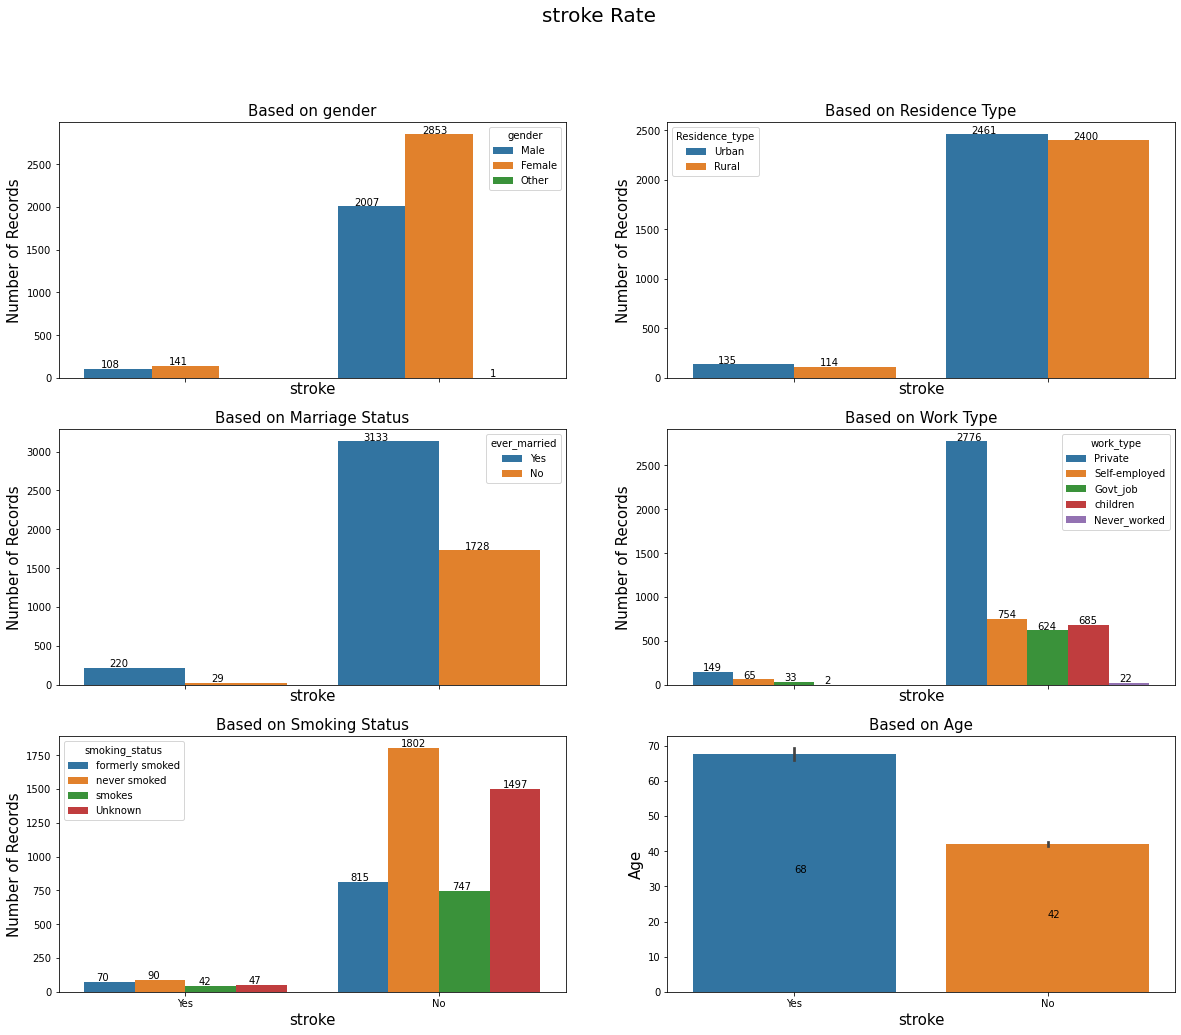

In [20]:
# kita akan mencari insight dari kolom stroke terhadap kolom kolom lain di data set ini
# agar lebih mudah dipahami saya akan mengganti nilai 0 menjadi No 
# dan 1 menjadi Yes pada kolom heart disease
data_vis.stroke = data_vis.stroke.replace({0:'No',1:'Yes'})
fig, axes = plt.subplots(3, 2, figsize=(20,16), sharey=False,sharex=True)
fig.suptitle('stroke Rate',fontsize=20)

# stroke Based on Gender
sns.countplot(ax=axes[0,0], data=data_vis, x='stroke', hue='gender',)
axes[0,0].set_title('Based on gender',fontsize=15)
axes[0,0].set_xlabel('stroke',fontsize=15)
axes[0,0].set_ylabel('Number of Records',fontsize=15)
for i in axes[0,0].patches:
   axes[0,0].text(i.get_x() + i.get_width()/4, i.get_height() + 10, "%.0f" % i.get_height())

# stroke Based on Residence Type
sns.countplot(ax=axes[0,1], data=data_vis,x='stroke',hue='Residence_type')
axes[0,1].set_title('Based on Residence Type',fontsize=15)
axes[0,1].set_xlabel('stroke',fontsize=15)
axes[0,1].set_ylabel('Number of Records',fontsize=15)
for  x in axes[0,1].patches:
   axes[0,1].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# stroke Based on Marriage Status
sns.countplot(ax=axes[1,0], data=data_vis,x='stroke',hue='ever_married')
axes[1,0].set_title('Based on Marriage Status',fontsize=15)
axes[1,0].set_xlabel('stroke',fontsize=15)
axes[1,0].set_ylabel('Number of Records',fontsize=15)
for  x in axes[1,0].patches:
   axes[1,0].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# stroke Based on Work Type
sns.countplot(ax=axes[1,1], data=data_vis,x='stroke',hue='work_type')
axes[1,1].set_title('Based on Work Type',fontsize=15)
axes[1,1].set_xlabel('stroke',fontsize=15)
axes[1,1].set_ylabel('Number of Records',fontsize=15)
for  x in axes[1,1].patches:
   axes[1,1].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

# stroke Based on Smoking Status
sns.countplot(ax=axes[2,0], data=data_vis,x='stroke',hue='smoking_status')
axes[2,0].set_title('Based on Smoking Status',fontsize=15)
axes[2,0].set_xlabel('stroke',fontsize=15)
axes[2,0].set_ylabel('Number of Records',fontsize=15)
for  x in axes[2,0].patches:
   axes[2,0].text( x.get_x() +  x.get_width()/4,  x.get_height() + 10, "%.0f" % x.get_height())

#stroke Based on age
sns.barplot(data=data_vis,y='age',x='stroke',ax=axes[2,1])
axes[2,1].set_title('Based on Age',fontsize=15)
axes[2,1].set_xlabel('stroke',fontsize=15)
axes[2,1].set_ylabel('Age',fontsize=15)
for  x in axes[2,1].patches:
   axes[2,1].text( x.get_x() +  x.get_width()/2,  x.get_height()/2, "%.0f" % x.get_height())



Secara garis besar grafik stroke similar seperti grafik heart disease dan hypertension sebelumnya, ini menunjukan bahwa kolom stroke, heart disease dan hipertensi memiliki korelasi yang hampir sama.


In [21]:
# kita akan mengecek korelasi dari ketiga kolom tersebut
data[['stroke','hypertension','heart_disease']].corr()

,stroke,hypertension,heart_disease
stroke,1.000000,0.127904,0.134914
hypertension,0.127904,1.000000,0.108306
heart_disease,0.134914,0.108306,1.000000


Ternyata korelasi antar kolom stroke, hypertension, dan heart_disease tidak signifikan, mungkin ini dikarenakan dataset yang imbalance dan cenderung pasien yang memiliki penyakit lebih sedikit dari pasien yang tidak memiliki.

### 2.2.4 Average Glucose Level

Text(0, 0.5, 'Age')

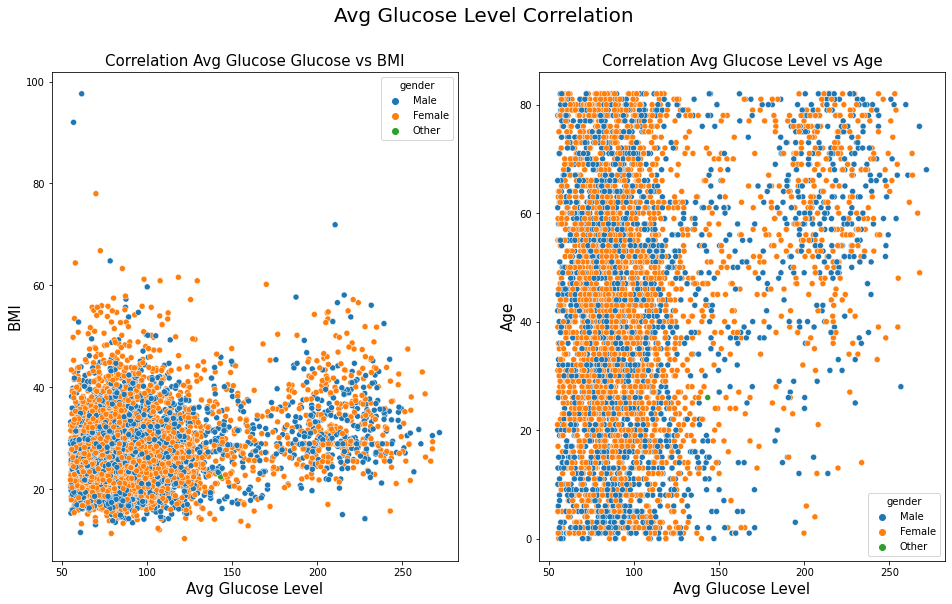

In [22]:
# kita akan mencari insight dari kolom avg glucose level terhadap kolom kolom lain di data set ini
fig, axes = plt.subplots(1, 2, figsize=(16,9), sharey=False,sharex=False)
fig.suptitle('Avg Glucose Level Correlation',fontsize=20)

# Correlation between avg_glucose_level and bmi
sns.scatterplot(data=data_vis,x='avg_glucose_level',y='bmi',hue='gender',ax=axes[0])
axes[0].set_title('Correlation Avg Glucose Glucose vs BMI',fontsize=15)
axes[0].set_ylabel('BMI',fontsize=15)
axes[0].set_xlabel('Avg Glucose Level',fontsize=15)

# correlation betewwn avg glucose level and age
sns.scatterplot(data=data_vis,x='avg_glucose_level',y='age',hue='gender',ax=axes[1])
axes[1].set_xlabel('Avg Glucose Level',fontsize=15)
axes[1].set_title('Correlation Avg Glucose Level vs Age',fontsize=15)
axes[1].set_ylabel('Age',fontsize=15)

In [23]:
# karena grafik tidak menunjukan korelasi 
# saya akan mengecek korelasi nya menggunakan metode pearson
data[['avg_glucose_level','bmi','age']].corr('pearson')['avg_glucose_level']

avg_glucose_level    1.000000
bmi                  0.168751
age                  0.238179
Name: avg_glucose_level, dtype: float64

Dapat dilihat di grafik tersebut bahwa antar kolom glukosa, bmi dan age tidak memiliki korelasi yang signifikan, kita buktikan dengan tabel korelasi di atas bahwa korelasinya 0,17 dan 0,24.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


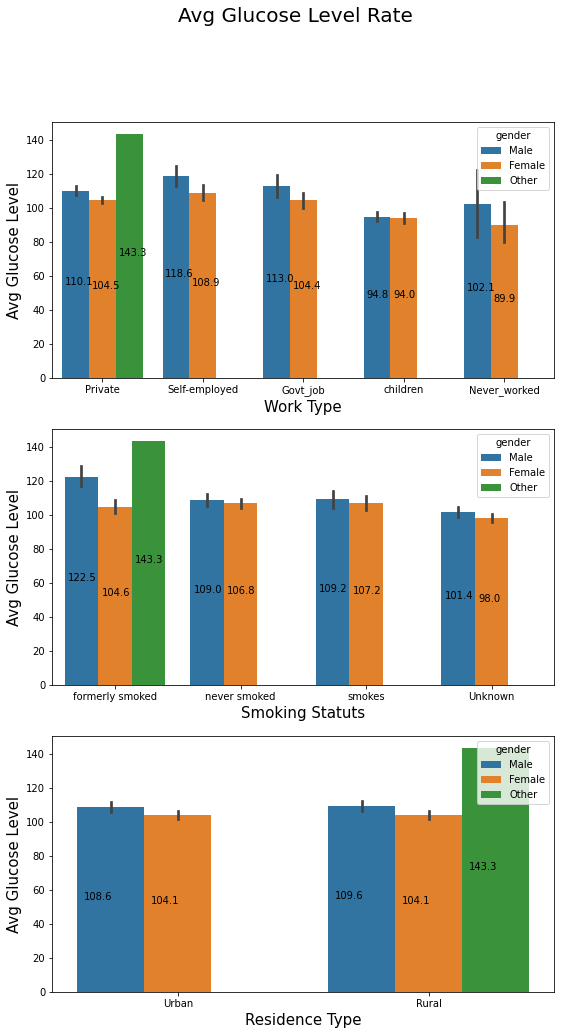

In [24]:
# membuat figure untuk membandingkan 3 plot
fig, axes = plt.subplots(3, 1, figsize=(9,16), sharey=True,sharex=False)
fig.suptitle('Avg Glucose Level Rate',fontsize=20)

# barplot avg glucose level based on Work type and gender
sns.barplot( data=data_vis,y='avg_glucose_level',x='work_type',hue='gender',ax=axes[0])
axes[0].set_ylabel('Avg Glucose Level',fontsize=15)
axes[0].set_xlabel('Work Type',fontsize=15)
for  x in axes[0].patches:
   axes[0].text( x.get_x() +  x.get_width()/10,  x.get_height()/2, "%.1f" % x.get_height())

# barplot avg glucose level Based on Smoking Status and gender
sns.barplot(ax=axes[1], data=data_vis,y='avg_glucose_level',x='smoking_status',hue='gender')
axes[1].set_xlabel('Smoking Statuts',fontsize=15)
axes[1].set_ylabel('Avg Glucose Level',fontsize=15)
for  x in axes[1].patches:
   axes[1].text( x.get_x() +  x.get_width()/10,  x.get_height()/2, "%.1f" % x.get_height())

# barplot avg glucose level Based on Residence Type
sns.barplot(data=data_vis,y='avg_glucose_level',x='Residence_type',ax=axes[2],hue='gender')
axes[2].set_xlabel('Residence Type',fontsize=15)
axes[2].set_ylabel('Avg Glucose Level',fontsize=15)
for  x in axes[2].patches:
   axes[2].text( x.get_x() +  x.get_width()/10,  x.get_height()/2, "%.1f" % x.get_height())



berdasarkan grafik di atas, dapat diketahui bahwa :
1. Pria cenderung memiliki kadar avg glucose level yang lebih tinggi dari pada perempuan.
2. Pria yang maupun perempuan dengan tipe Pekerjaan Self-employed memiliki kadar avg glucose level yang lebih tinggi dari pada tipe pekerjaan lain.
3. Pria yang sudah berhenti merokok memiliki kadar avg glucose lebih tinggi dari pria lain, sedangkan peremuan yang merokok memiliki kadar avg glucose yang lebih tinggi dari perempuan yang lain.
4. Pria maupun perempuan yang tinggal di area urban maupun rural memiliki kadar glukosa yang hampir sama. 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


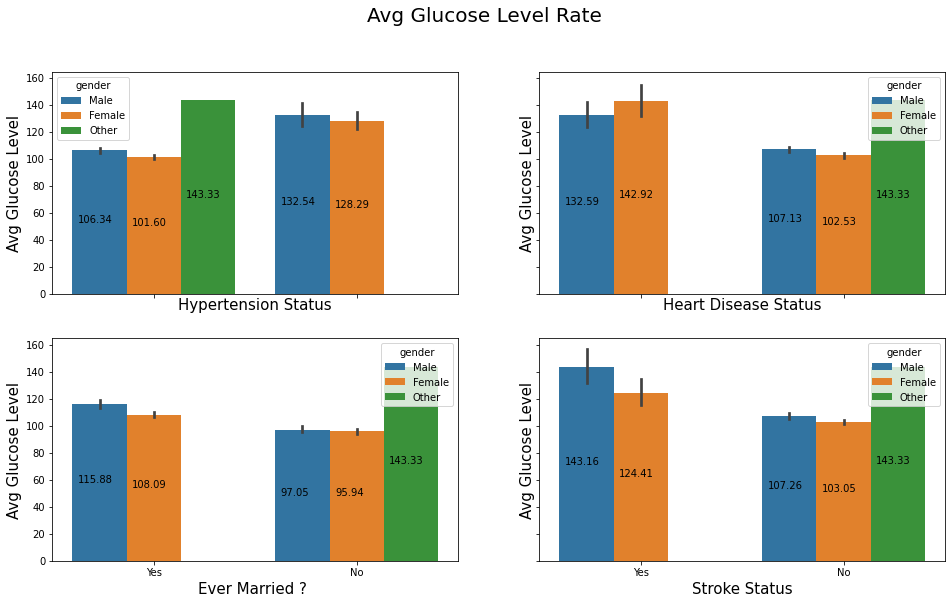

In [25]:
# membuat figure dengan 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16,9), sharey=True,sharex=True)
fig.suptitle('Avg Glucose Level Rate',fontsize=20)
# avg glucose level based on hypertension status
sns.barplot( data=data_vis,y='avg_glucose_level',x='hypertension',hue='gender',ax=axes[0,0])
axes[0,0].set_ylabel('Avg Glucose Level',fontsize=15)
axes[0,0].set_xlabel('Hypertension Status',fontsize=15)
for  x in axes[0,0].patches:
   axes[0,0].text(x.get_x() +  x.get_width()/10,  x.get_height()/2, "%.2f" % x.get_height())

# avg glucose level Based on heart disease status
sns.barplot(ax=axes[0,1], data=data_vis,y='avg_glucose_level', x='heart_disease',hue='gender')
axes[0,1].set_ylabel('Avg Glucose Level',fontsize=15)
axes[0,1].set_xlabel('Heart Disease Status',fontsize=15)
for  x in axes[0,1].patches:
   axes[0,1].text(x.get_x() +  x.get_width()/10,  x.get_height()/2, "%.2f" % x.get_height())

#avg glucose level Based on Marriage Status
sns.barplot(data=data_vis,y='avg_glucose_level',x='ever_married',ax=axes[1,0],hue='gender')
axes[1,0].set_ylabel('Avg Glucose Level',fontsize=15)
axes[1,0].set_xlabel('Ever Married ? ',fontsize=15)
for  x in axes[1,0].patches:
   axes[1,0].text(x.get_x() +  x.get_width()/10,  x.get_height()/2, "%.2f" % x.get_height())

#avg glucose level Based on Stroke Status
sns.barplot(data=data_vis,y='avg_glucose_level',x='stroke',ax=axes[1,1],hue='gender')
axes[1,1].set_ylabel('Avg Glucose Level',fontsize=15)
axes[1,1].set_xlabel('Stroke Status',fontsize=15)
for  x in axes[1,1].patches:
   axes[1,1].text(x.get_x() +  x.get_width()/10,  x.get_height()/2, "%.2f" % x.get_height())

Dari grafik di atas dapat diketahui bahwa :
1. Pria cenderung memiliki kadar avg glucose level yang lebih tinggi dari pada perempuan.
2. Pasien (Pria maupun perempuan) yang tidak memiliki hipertensi memiliki kadar avg glukosa yang lebih tinggi dari pada yang memiliki hipertensi.
3. Pasien (pria maupun perempuan) yang memiliki penyakit jantung memiiki kadar avg glukosa yang lebih tinggi dari pada yang tidak memiliki penyakit jantung.
4. Pasien yang pernah menikah memiliki kadar glukosa yang lebih tinggi dari pada yang belum menikah.
5. pasien yang mempunyai stroke memiliki kadar glukosa yang lebih tinggi dari pada yang tidak mempunyai stroke.

## 2.3 Handling Outliers

Apabila dirasa sudah cukup insight yang didapat dari dataset, saya akan melanjutkan ke tahap selanjutnya yaitu handling outliers. saya akan mengecek outliers tiap kolom, namun perlu hati - hati karena bisa saja outliers tersebut salah input atau memang dia anomali.
seperti repository sebelumnya saya akan menggunakan Inter Quartile Range (IQR) untuk menangani outliers. Q1 = 25 % dan Q3 75 %

In [26]:
# saya akan membuat class outliers dan mendefinisikan fungsi untuk menentukan limit 
# dan mencari data dalam limit tersebut
class outliers():
    # membuat fungsi limit dengan parameter kolom dari dataset
    def limit(self,i):
        self.Q1 = data[i].quantile(0.25)
        self.Q3 = data[i].quantile(0.75)
        self.IQR = self.Q3 - self.Q1
        # saya akan membuat limit extreme dari Q1 dan Q3
        self.lower = data[i].quantile(0.25) - (self.IQR*1.5)
        self.lower_extreme = data[i].quantile(0.25) - (self.IQR*3)
        self.upper = data[i].quantile(0.75) + (self.IQR*1.5)
        self.upper_extreme = data[i].quantile(0.75) + (self.IQR*3)
        print(f'Lower Limit = {self.lower}')
        print(f'Lower Extreme Limit = {self.lower_extreme}')
        print(f'Upper Limit = {self.upper}')
        print(f'Upper Extreme Limit = {self.upper_extreme}')
    # membuat fungsi untuk mengetahui berapa persen outliers pada dataset
    def percent_outliers(self,i):
        print(f'{data[(data[i] <= self.lower)].shape[0]/data[i].shape[0]*100} % of data whitin Lower Limit')
        print(f'{data[(data[i] <= self.lower_extreme)].shape[0]/data[i].shape[0]*100} % of data within Lower Extreme Limit')
        print(f'{data[(data[i] >= self.upper)].shape[0]/data[i].shape[0]*100} % of data within Upper Limit')
        print(f'{data[(data[i] >= self.upper_extreme)].shape[0]/data[i].shape[0]*100} % of data within Upper Extreme Limit')

Lower Limit = -29.0
Lower Extreme Limit = -83.0
Upper Limit = 115.0
Upper Extreme Limit = 169.0
None
0.0 % of data whitin Lower Limit
0.0 % of data within Lower Extreme Limit
0.0 % of data within Upper Limit
0.0 % of data within Upper Extreme Limit
None


Text(0.5, 0, 'Jumlah')

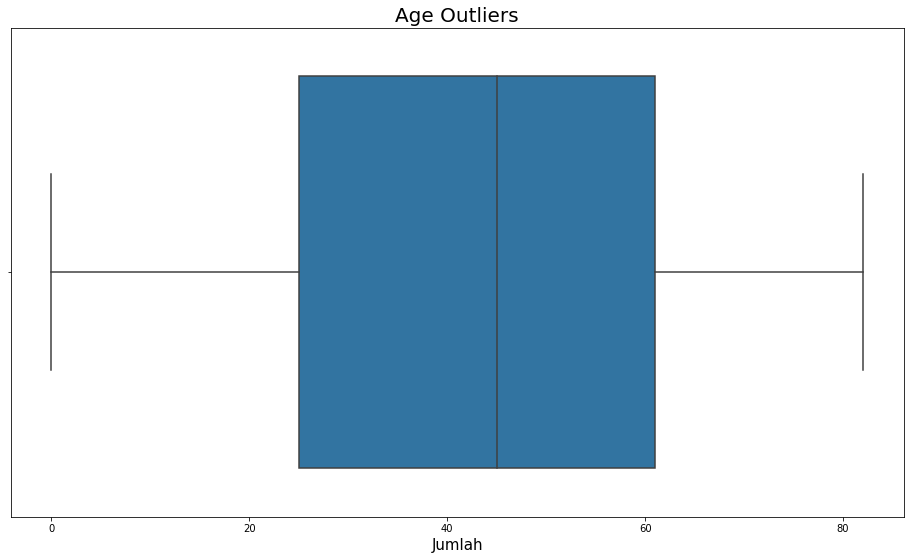

In [27]:
# saya akan mengecek limit dan persen limit pada kolom age
ol = outliers()
print(ol.limit('age'))
print('='*50)
print(ol.percent_outliers('age'))

# membuat boxplot kolom age untuk melakukan pengecekan pada outliers
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=data, x='age')
plt.title('Age Outliers',fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

berdasarkan fungsi dan grafik tidak ada outliers pada kolom ini

Lower Limit = 21.977500000000006
Lower Extreme Limit = -33.28999999999999
Upper Limit = 169.35750000000002
Upper Extreme Limit = 224.625
None
0.0 % of data whitin Lower Limit
0.0 % of data within Lower Extreme Limit
12.270058708414872 % of data within Upper Limit
3.24853228962818 % of data within Upper Extreme Limit
None


Text(0.5, 0, 'Jumlah')

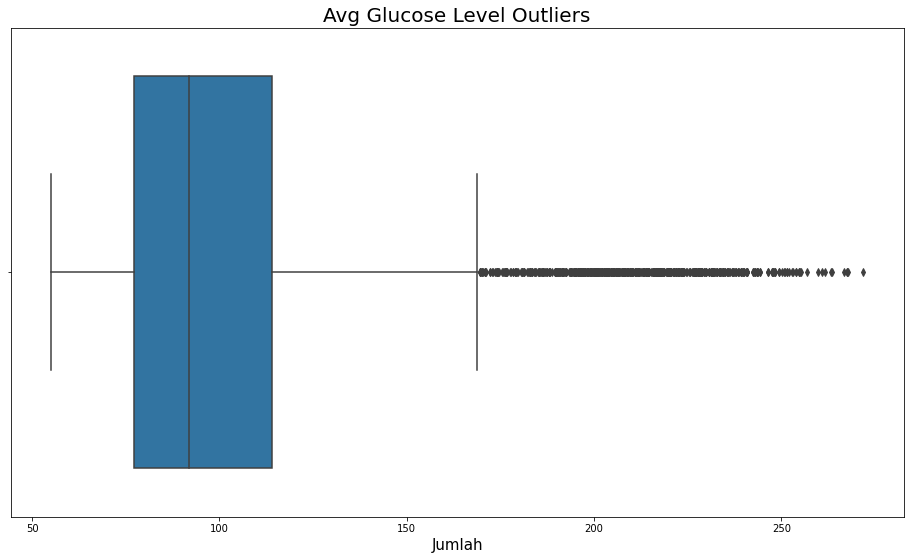

In [28]:
# saya akan mengecek limit dan persen outliers dari kolom avg_glucose_level
print(ol.limit('avg_glucose_level'))
print('='*50)
print(ol.percent_outliers('avg_glucose_level'))

# mengecek outliers dengan boxplot
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=data,x='avg_glucose_level')
plt.title('Avg Glucose Level Outliers', fontsize=20)
plt.xlabel('Jumlah',fontsize=15)

Karena terdapat 15 % outliers pada data pada kolom avg glucose level, saya tidak akan mendrop nya karena akan kehilangan data yang banyak. Pada project sebelumnya saya menggunakan natural log transformasi. natural log transformation digunakan untuk menangani outliers karena metode ini membantu mengurangi skewness pada dataset yang biasanya menyebabkan adanya outliers. natural log menggunakan angka euler sebagai base logaritma nya, angka euler adalah konstanta dengan nilai 2.718282.
Namun pada data ini saya akan menggunakan mean normalization yaitu dengan mengurangi setiap nilai dari data tsb dengan mean dan membagi nya dengan selisih nilai max dan min dari data tsb. alasannya karena menggunakan natural log sisa outliers masih banyak sekitar 7 %. 


In [29]:
# saya akan drop 2% data yang berada di atas upper extreme
data.drop(data[(data.avg_glucose_level > ol.upper_extreme)].index, inplace=True)
# lalu melakukan log transformasi untuk sisa outliers
data.avg_glucose_level = np.log(data.avg_glucose_level)

(array([ 379.,  575.,  943., 1015.,  781.,  469.,  197.,  124.,  135.,
        326.]), array([4.00951263, 4.1497706 , 4.29002858, 4.43028655, 4.57054453,
       4.7108025 , 4.85106048, 4.99131845, 5.13157643, 5.27183441,
       5.41209238]), <BarContainer object of 10 artists>)
0.8373976433986738
Lower Limit = 3.7781936195229067
Lower Extreme Limit = 3.2173007275532814
Upper Limit = 5.273907998108574
Upper Extreme Limit = 5.834800890078199
None
0.0 % of data whitin Lower Limit
0.0 % of data within Lower Extreme Limit
6.492718446601941 % of data within Upper Limit
0.0 % of data within Upper Extreme Limit
None


Text(0.5, 0, 'Jumlah')

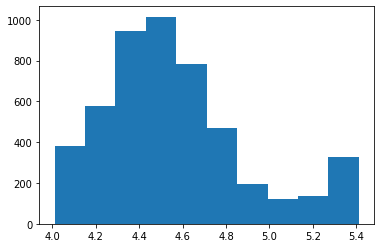

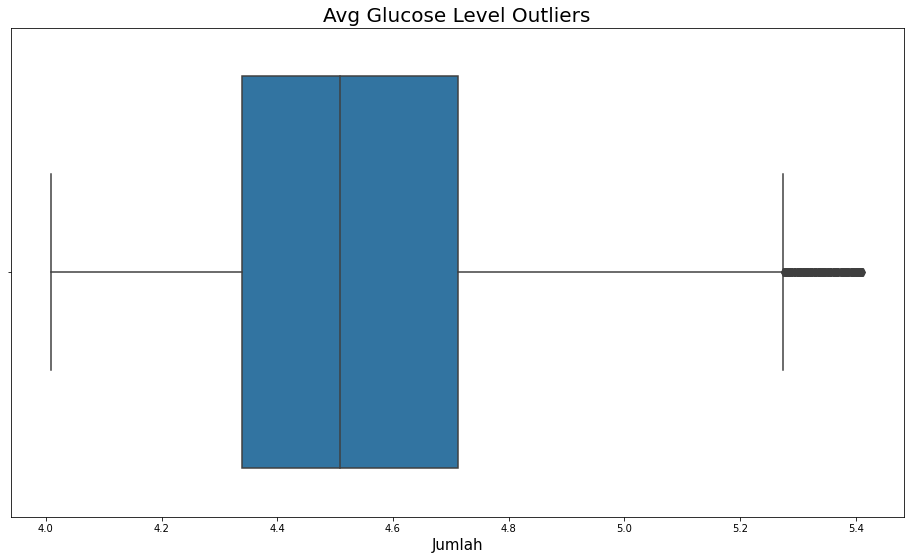

In [30]:
# kolom avg glucose level setelah dilakukan transformasi
print(plt.hist(data.avg_glucose_level))
print(data.avg_glucose_level.skew())
print(ol.limit('avg_glucose_level'))
print('='*50)
print(ol.percent_outliers('avg_glucose_level'))
# mengecek outliers dengan boxplot
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=data,x='avg_glucose_level')
plt.title('Avg Glucose Level Outliers', fontsize=20)
plt.xlabel('Jumlah',fontsize=15)

In [31]:
# karena masih ada sisa 6% outliers, saya akan drop saja
data.drop(data[(data.avg_glucose_level >= ol.upper)].index, inplace=True)
print(ol.percent_outliers('avg_glucose_level'))

0.0 % of data whitin Lower Limit
0.0 % of data within Lower Extreme Limit
0.0 % of data within Upper Limit
0.0 % of data within Upper Extreme Limit
None


dapat dilihat pada grafik histogram terdapat perubahan pada distribusi nya dimana skewness nya berkurang menjadi 0,8 dari sebelumnya 1,5. outliers juga berkurang menjadi 1,5 % pada tahap ini tidak diperlukan mendrop outliers ini karena range nilai nya sudah dilakukan normalization (antara -1 dan 1).

Lower Limit = 10.05
Lower Extreme Limit = -3.299999999999997
Upper Limit = 45.64999999999999
Upper Extreme Limit = 58.99999999999999
None
0.0 % of data whitin Lower Limit
0.0 % of data within Lower Extreme Limit
2.292883409041748 % of data within Upper Limit
0.28120268224096906 % of data within Upper Extreme Limit
None


Text(0.5, 0, 'Jumlah')

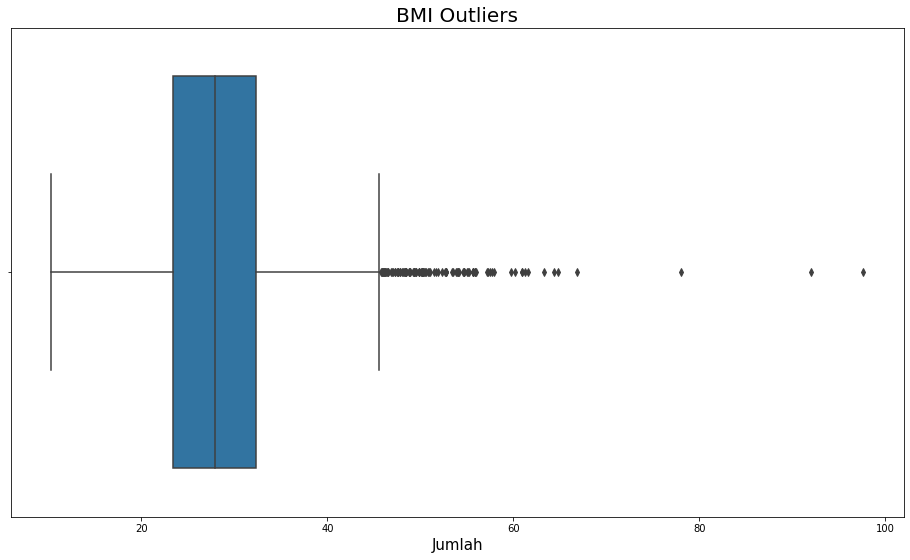

In [32]:
# saya akan mengecek limit dan persen outliers dari bmi
print(ol.limit('bmi'))
print('='*50)
print(ol.percent_outliers('bmi'))

# mengecek outliers dengan boxplot
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=data,x='bmi')
plt.title('BMI Outliers', fontsize=20)
plt.xlabel('Jumlah',fontsize=15)

In [33]:
# karena hanya 3 % dari data merupakan outliers saya akan drop saja. 
data.drop(data[(data.bmi < ol.lower)].index, inplace=True)
data.drop(data[(data.bmi > ol.upper)].index, inplace=True)


Lower Limit = 10.400000000000004
Lower Extreme Limit = -2.499999999999993
Upper Limit = 44.8
Upper Extreme Limit = 57.69999999999999
None
0.022138587558113793 % of data whitin Lower Limit
0.0 % of data within Lower Extreme Limit
0.531326101394731 % of data within Upper Limit
0.0 % of data within Upper Extreme Limit
None


Text(0.5, 0, 'Jumlah')

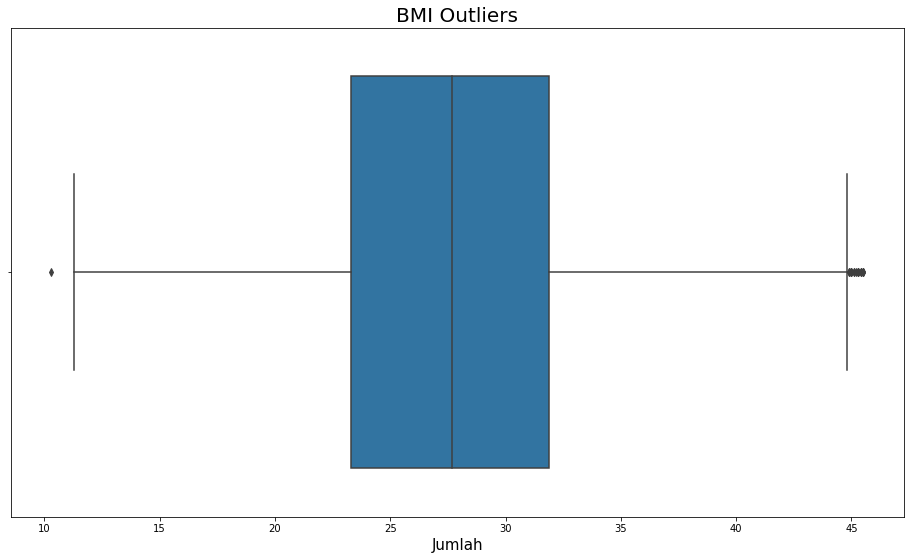

In [34]:
# saya akan mengecek lagi limit dan persen outliers dari bmi
print(ol.limit('bmi'))
print('='*50)
print(ol.percent_outliers('bmi'))

# mengecek outliers dengan boxplot
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=data,x='bmi')
plt.title('BMI Outliers', fontsize=20)
plt.xlabel('Jumlah',fontsize=15)

Lower Limit = 10.55
Lower Extreme Limit = -2.1999999999999993
Upper Limit = 44.55
Upper Extreme Limit = 57.3
None
0.022237046920169 % of data whitin Lower Limit
0.0 % of data within Lower Extreme Limit
0.22237046920169004 % of data within Upper Limit
0.0 % of data within Upper Extreme Limit
None


Text(0.5, 0, 'Jumlah')

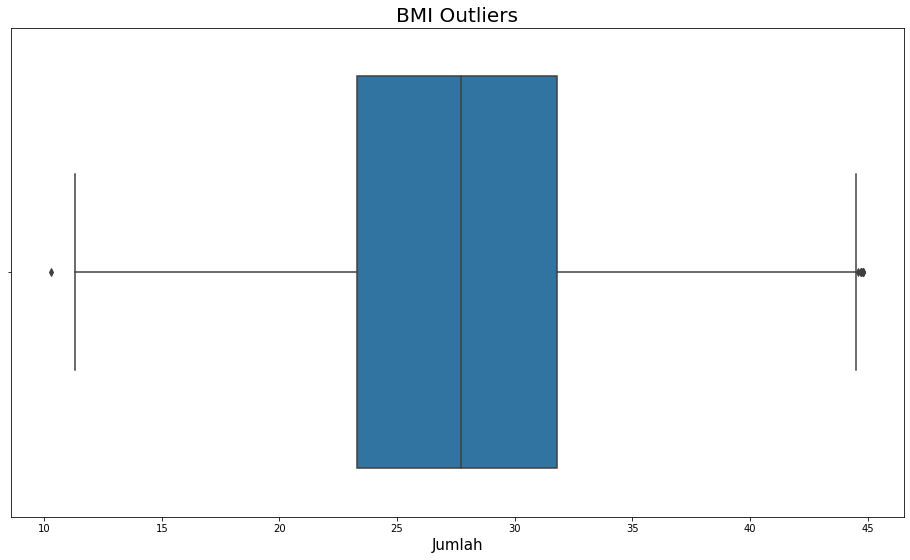

In [35]:
# karena masih ada 0.4 % outliers kita drop lagi. 
data.drop(data[(data.bmi > ol.upper)].index, inplace=True)
# saya akan mengecek lagi limit dan persen outliers dari bmi
print(ol.limit('bmi'))
print('='*50)
print(ol.percent_outliers('bmi'))

# mengecek outliers dengan boxplot
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=data,x='bmi')
plt.title('BMI Outliers', fontsize=20)
plt.xlabel('Jumlah',fontsize=15)

Setelah dikira cukup menangani outliers, saya akan memasuki tahap selanjutnya yaitu feature selection.

## 2.5 Feature Selection

Tahap ini saya akan memilih atau mencari feature mana saja yang paling relefan dengan target kita. Saya kan menggunakan feature importance. 

In [36]:
# sebelum melakukan selection saya akan mengubah data string menjadi kategori
# mendrop kolom id
data.ever_married.replace({'Yes':1, 'No':0},inplace=True)
data.work_type.replace({'Never_worked':0,'Govt_job':1,'children':2,'Self-employed':3,'Private':4},inplace=True)
data.Residence_type.replace({'Rural':0,'Urban':1},inplace=True)
data.smoking_status.replace({'smokes':0, 'formerly smoked':1, 'Unknown':2, 'never smoked':3},inplace=True)
data.gender.replace({'Other':0, 'Male':1, 'Female':2},inplace=True)
data.drop(columns='id',inplace=True)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


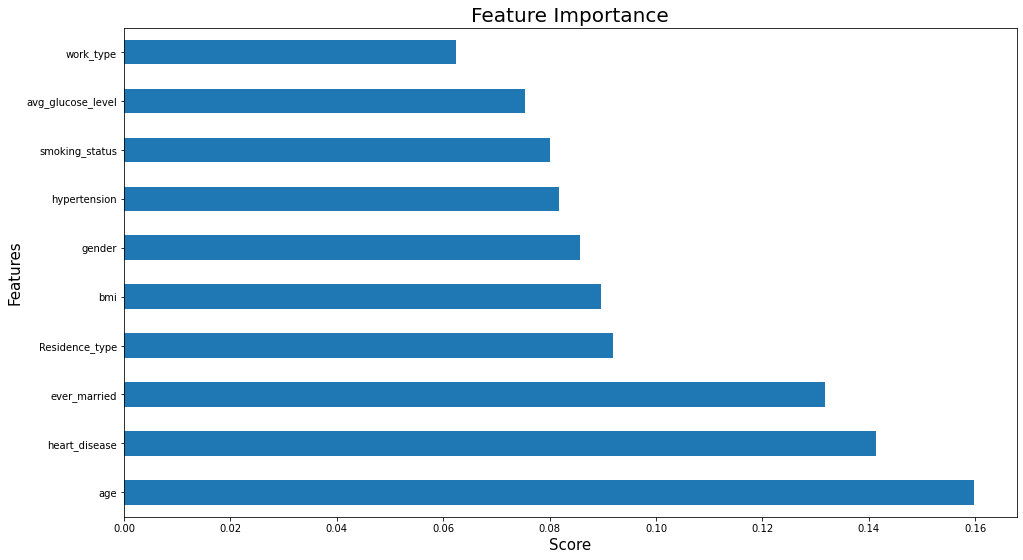

In [37]:
y = data['stroke']
X = data.drop(columns=['stroke'], axis=1)

#kita coba menggunakan fetaure importance pada model XGboost
model = XGBClassifier()
model.fit(X,y)

#Kita visualisasi feature yang penting-penting
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
f, ax = plt.subplots(figsize=(16,9))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance', fontsize=20)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Score', fontsize=15)
plt.show()

karena sedikit nya feature dan dilihat dari score nya cukup signifikan saya tidak akan mendrop feature - feature pada data set ini

In [38]:
data.shape

(4497, 11)

## 2.6 Imbalance Dataset

karena target variabel memiliki ketidak seimbangan data antara True dan False yang cukup jauh, perlu dilakukan balancing agar hasil prediksi tidak bias atau menunjukan False Positive.

<AxesSubplot:xlabel='count', ylabel='stroke'>

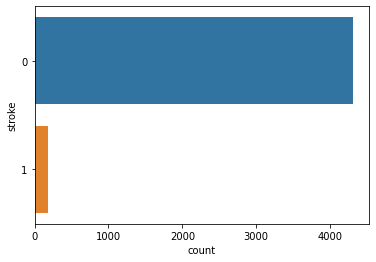

In [39]:
#Visualisasi Imbalance Dataset Sebelum Dibenahi
sns.countplot(y="stroke",data=data)

bisa dilihat target variabel nya menunjukan imbalance antara 0 (Tidak Stroke) dan 1( stroke) apabila tidak ditangani dapat menyebabkan model kita melakukan salah prediksi atau False Positive

In [40]:
# kita cek ratio target variabel kita antara value 0 dan 1
print(data.stroke.value_counts())
print('-'*50)
print(f'Does not have strok : {data[(data.stroke == 0)].shape[0]/data.shape[0]*100} %')
print(f'Does have stroke : {data[(data.stroke == 1)].shape[0]/data.shape[0]*100} %')

0    4315
1     182
Name: stroke, dtype: int64
--------------------------------------------------
Does not have strok : 95.95285746052924 %
Does have stroke : 4.047142539470759 %


Dengan 90 % perbedaan ratio target variabel dataset ini menunjukan dataset ini sangat tidak seimbang. 

In [41]:
# saya akan membagi dataset menjadi x dan y dimana y adalah target variabel (stroke)
y = data.stroke
x = data.drop(columns=['stroke'],axis=1)
# melakukan scaling pada data dengan kolom int agar nilai dari data nya tidak terlalu bervariasi


# 3. Modelling

Setelah semua data sudah bersih dan siap dimasukkan ke dalam model, maka ini saatnya kita membuat model dan mencari model yang paling optimal. 
Sebelum di fitting ke model saya akan melakukan resampling menggunakan 4 metode yang berbeda untuk tiap algorithma dan agar memudahkan melihat model mana yang paling optimal, saya akan langsung evaluasi setela membuat model, dilatih dan dites.

In [42]:
# membuat class modelling yang berisi fungsi resampling dan model fitting dan evaluasi 
class modelling():
    # membuat fungsi resampling
    def resampling(self,method, x, y):
        x_resamp, y_resamp = method.fit_resample(x, y)
        # melakukan standarization pada value
                # membagi data menjadi train dan test pada x dan y dengan train data size 0.75
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x_resamp, y_resamp, train_size=0.75, random_state=25,stratify=y_resamp)
    # membuat fungsi model fitting dan evaluasi
    def model_fit_eval(self,ml):
        # fitting train data
        ml.fit(self.x_train, self.y_train)
        # predict test data
        yhat = ml.predict(self.x_test)
        yhat_proba = ml.predict_proba(self.x_test)[:,0]
        y_proba = ml.predict_proba(self.x_test)
        # confussion matrix
        plot_confusion_matrix(ml,self.x_test,self.y_test)
        plt.show()
        print('='*100)
        print('Classification Report : \n', classification_report(self.y_test, yhat, digits=3))
        print('='*100)

        #Evaluasi ROC Curve
        skplt.metrics.plot_roc(self.y_test, y_proba)

        #Evaluasi Precission Recall Curve
        skplt.metrics.plot_precision_recall(self.y_test, y_proba)
        plt.show()
        

## 3.1 Logistic Regression

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


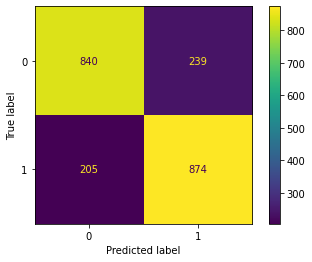

Classification Report : 
               precision    recall  f1-score   support

           0      0.804     0.778     0.791      1079
           1      0.785     0.810     0.797      1079

    accuracy                          0.794      2158
   macro avg      0.795     0.794     0.794      2158
weighted avg      0.795     0.794     0.794      2158



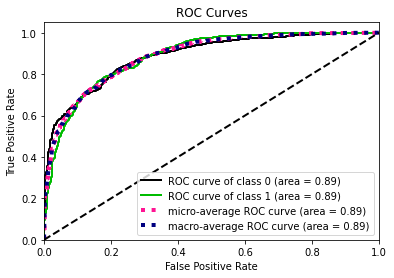

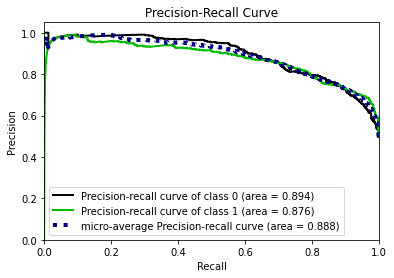

In [43]:
# Logistic Regression
mod = modelling()
lr = LogisticRegression()
smote = SMOTE()
mod.resampling(smote, x, y)
mod.model_fit_eval(lr)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


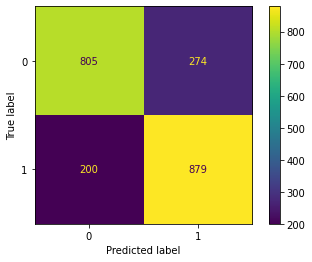

Classification Report : 
               precision    recall  f1-score   support

           0      0.801     0.746     0.773      1079
           1      0.762     0.815     0.788      1079

    accuracy                          0.780      2158
   macro avg      0.782     0.780     0.780      2158
weighted avg      0.782     0.780     0.780      2158



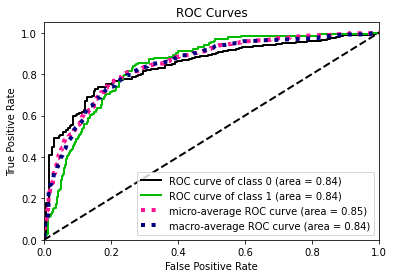

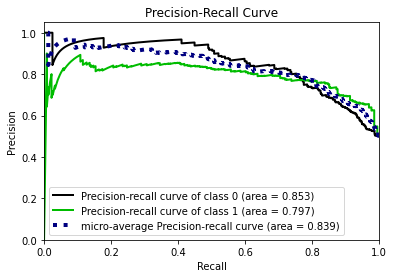

In [44]:
from imblearn.over_sampling import RandomOverSampler
rs = RandomOverSampler()
mod.resampling(rs, x, y)
mod.model_fit_eval(lr)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


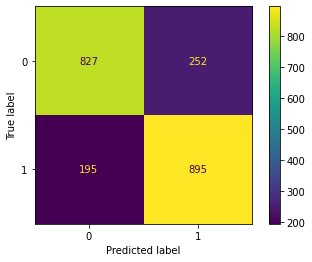

Classification Report : 
               precision    recall  f1-score   support

           0      0.809     0.766     0.787      1079
           1      0.780     0.821     0.800      1090

    accuracy                          0.794      2169
   macro avg      0.795     0.794     0.794      2169
weighted avg      0.795     0.794     0.794      2169



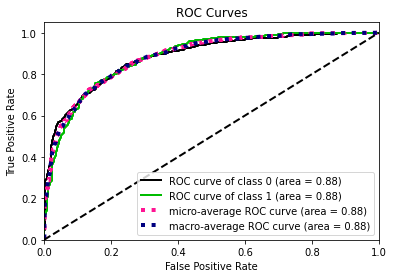

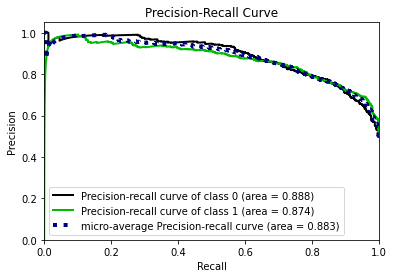

In [45]:
from imblearn.over_sampling import ADASYN
ada = ADASYN()
mod.resampling(ada, x, y)
mod.model_fit_eval(lr)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


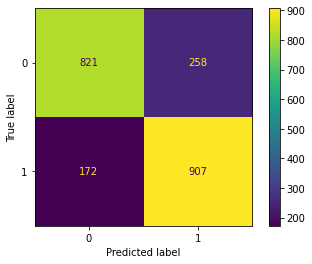

Classification Report : 
               precision    recall  f1-score   support

           0      0.827     0.761     0.792      1079
           1      0.779     0.841     0.808      1079

    accuracy                          0.801      2158
   macro avg      0.803     0.801     0.800      2158
weighted avg      0.803     0.801     0.800      2158



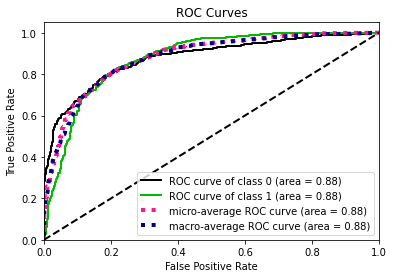

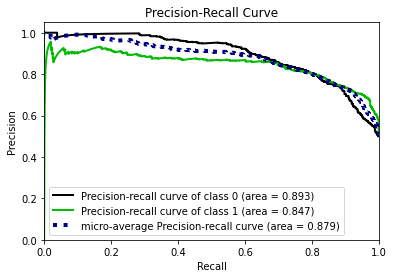

In [46]:
from imblearn.over_sampling import SMOTENC
smotenc = SMOTENC(categorical_features = [0,2])
mod.resampling(smotenc, x, y)
mod.model_fit_eval(lr)

## 3.2 Naive Bayes

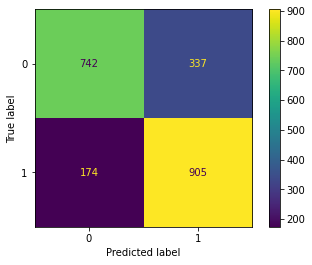

Classification Report : 
               precision    recall  f1-score   support

           0      0.810     0.688     0.744      1079
           1      0.729     0.839     0.780      1079

    accuracy                          0.763      2158
   macro avg      0.769     0.763     0.762      2158
weighted avg      0.769     0.763     0.762      2158



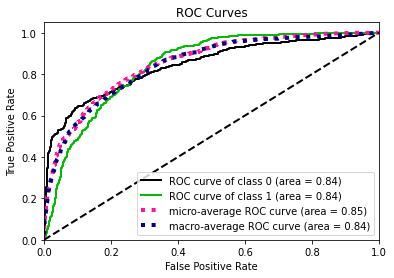

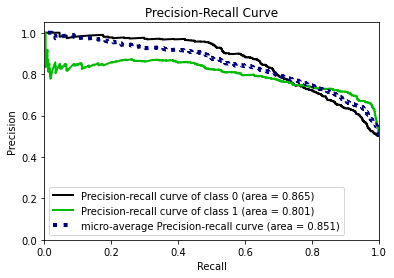

In [47]:
# sekarang saya akan mencoba menggunakan Naive Bayes 
nb = GaussianNB()
# resampling SMOTE
mod.resampling(smote, x, y)
mod.model_fit_eval(nb)

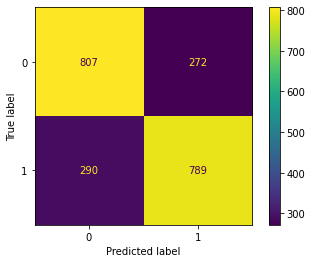

Classification Report : 
               precision    recall  f1-score   support

           0      0.736     0.748     0.742      1079
           1      0.744     0.731     0.737      1079

    accuracy                          0.740      2158
   macro avg      0.740     0.740     0.740      2158
weighted avg      0.740     0.740     0.740      2158



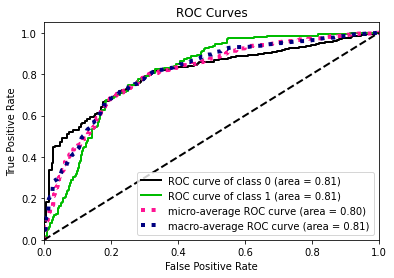

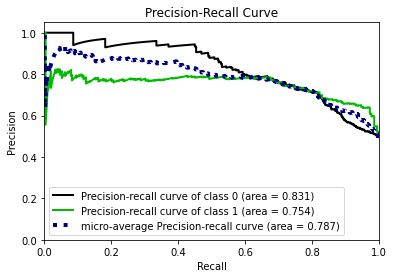

In [48]:
# resampling RandomOVerSampler
mod.resampling(rs, x, y)
mod.model_fit_eval(nb)

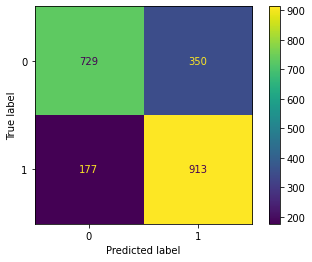

Classification Report : 
               precision    recall  f1-score   support

           0      0.805     0.676     0.735      1079
           1      0.723     0.838     0.776      1090

    accuracy                          0.757      2169
   macro avg      0.764     0.757     0.755      2169
weighted avg      0.764     0.757     0.755      2169



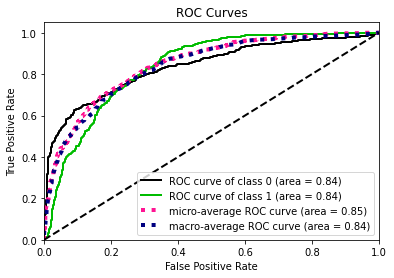

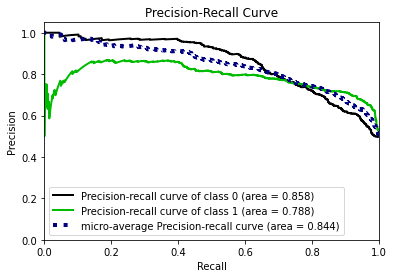

In [49]:
# resampling menggunakan ADASYN
mod.resampling(ada, x, y)
mod.model_fit_eval(nb)

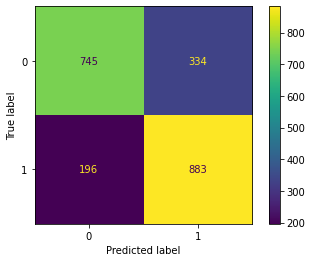

Classification Report : 
               precision    recall  f1-score   support

           0      0.792     0.690     0.738      1079
           1      0.726     0.818     0.769      1079

    accuracy                          0.754      2158
   macro avg      0.759     0.754     0.753      2158
weighted avg      0.759     0.754     0.753      2158



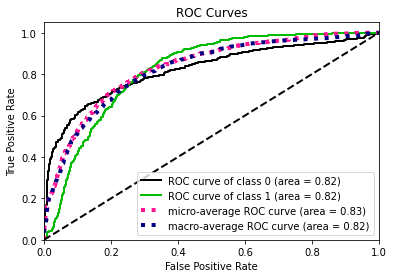

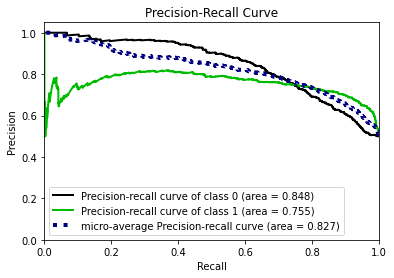

In [50]:
# resampling menggunakan SMOTENC
mod.resampling(smotenc, x, y)
mod.model_fit_eval(nb)

## 3.3 KNearest Neighbor

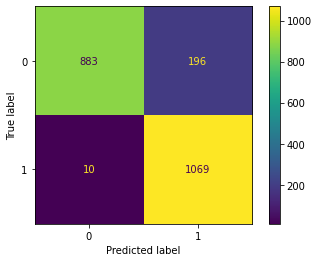

Classification Report : 
               precision    recall  f1-score   support

           0      0.989     0.818     0.896      1079
           1      0.845     0.991     0.912      1079

    accuracy                          0.905      2158
   macro avg      0.917     0.905     0.904      2158
weighted avg      0.917     0.905     0.904      2158



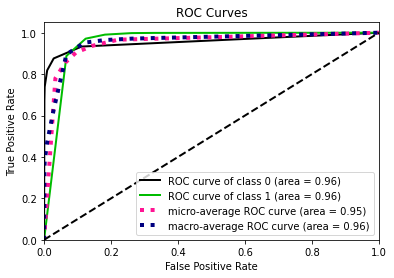

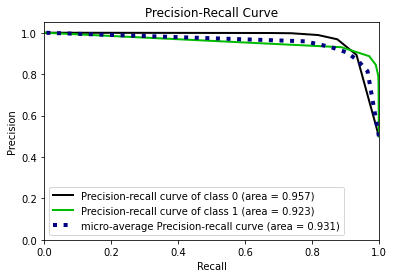

In [51]:
# saya akan mencoba menggunakan KNN
knn = KNeighborsClassifier()
# resampling menggunakan SMOTE
mod.resampling(smote, x, y)
mod.model_fit_eval(knn)

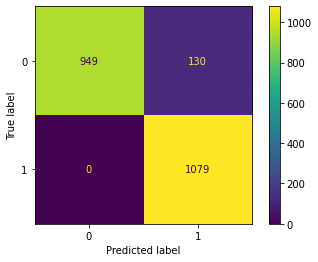

Classification Report : 
               precision    recall  f1-score   support

           0      1.000     0.880     0.936      1079
           1      0.892     1.000     0.943      1079

    accuracy                          0.940      2158
   macro avg      0.946     0.940     0.940      2158
weighted avg      0.946     0.940     0.940      2158



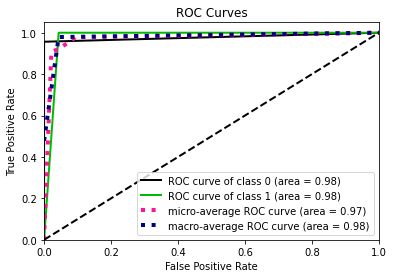

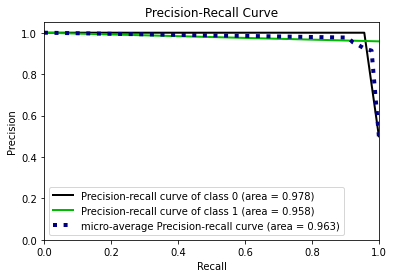

In [52]:
# resampling RandomOverSampler
mod.resampling(rs, x, y)
mod.model_fit_eval(knn)

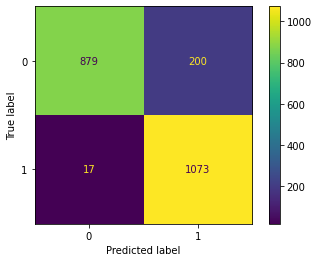

Classification Report : 
               precision    recall  f1-score   support

           0      0.981     0.815     0.890      1079
           1      0.843     0.984     0.908      1090

    accuracy                          0.900      2169
   macro avg      0.912     0.900     0.899      2169
weighted avg      0.912     0.900     0.899      2169



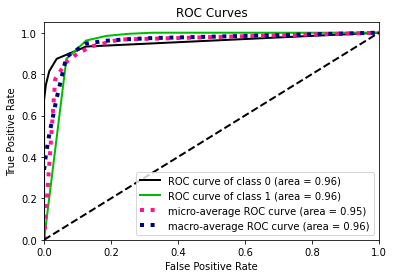

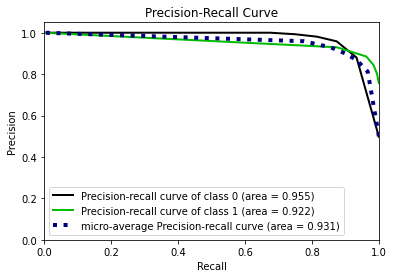

In [53]:
# resampling ADASYN
mod.resampling(ada, x, y)
mod.model_fit_eval(knn)

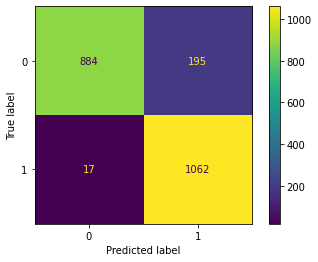

Classification Report : 
               precision    recall  f1-score   support

           0      0.981     0.819     0.893      1079
           1      0.845     0.984     0.909      1079

    accuracy                          0.902      2158
   macro avg      0.913     0.902     0.901      2158
weighted avg      0.913     0.902     0.901      2158



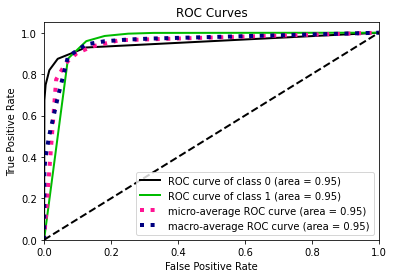

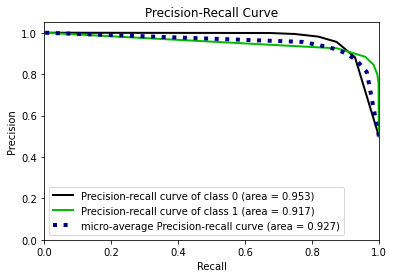

In [54]:
# resampling SMOTENC
mod.resampling(smotenc, x, y)
mod.model_fit_eval(knn)

## 3.4 Random Forrest 

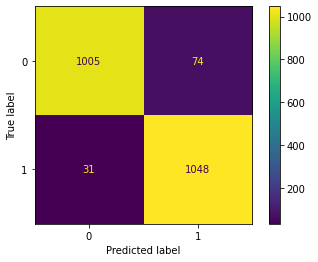

Classification Report : 
               precision    recall  f1-score   support

           0      0.970     0.931     0.950      1079
           1      0.934     0.971     0.952      1079

    accuracy                          0.951      2158
   macro avg      0.952     0.951     0.951      2158
weighted avg      0.952     0.951     0.951      2158



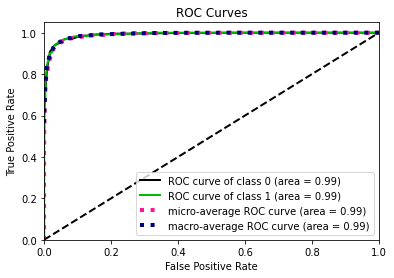

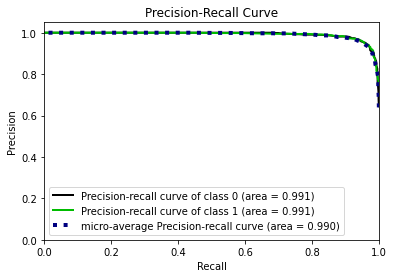

In [55]:
# sekarang saya akan mencoba random forrest
rf = RandomForestClassifier()
# resampling SMOTE
mod.resampling(smote, x, y)
mod.model_fit_eval(rf)

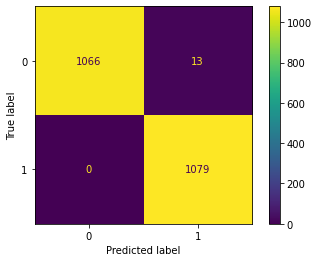

Classification Report : 
               precision    recall  f1-score   support

           0      1.000     0.988     0.994      1079
           1      0.988     1.000     0.994      1079

    accuracy                          0.994      2158
   macro avg      0.994     0.994     0.994      2158
weighted avg      0.994     0.994     0.994      2158



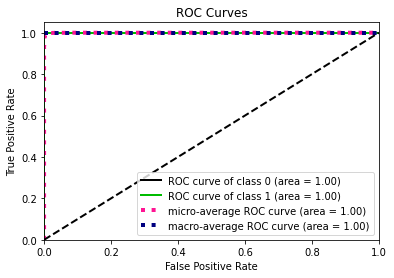

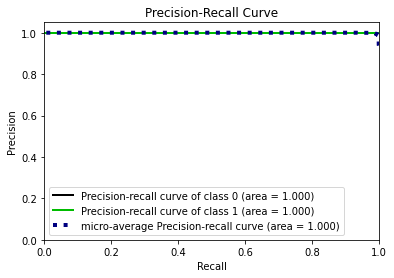

In [56]:
# resampling RandomOverSampler
mod.resampling(rs, x, y)
mod.model_fit_eval(rf)

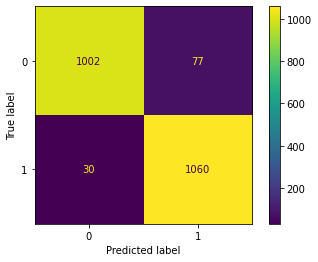

Classification Report : 
               precision    recall  f1-score   support

           0      0.971     0.929     0.949      1079
           1      0.932     0.972     0.952      1090

    accuracy                          0.951      2169
   macro avg      0.952     0.951     0.951      2169
weighted avg      0.952     0.951     0.951      2169



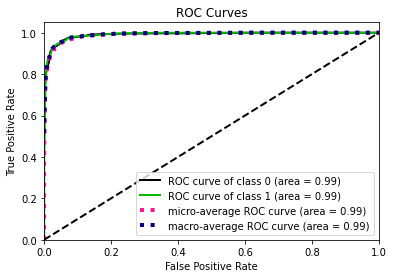

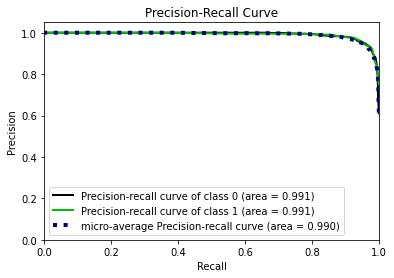

In [57]:
# resampling ADASYN
mod.resampling(ada, x, y)
mod.model_fit_eval(rf)

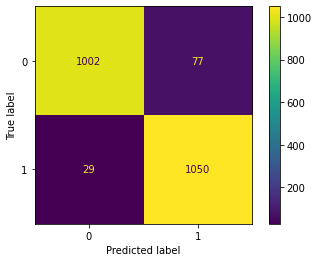

Classification Report : 
               precision    recall  f1-score   support

           0      0.972     0.929     0.950      1079
           1      0.932     0.973     0.952      1079

    accuracy                          0.951      2158
   macro avg      0.952     0.951     0.951      2158
weighted avg      0.952     0.951     0.951      2158



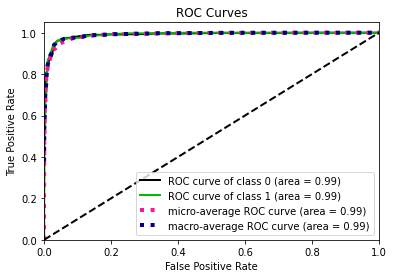

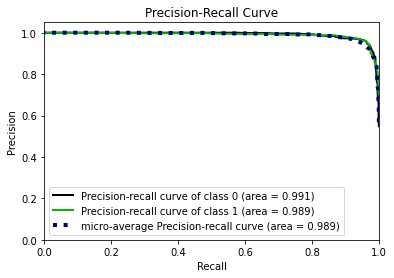

In [58]:
# resampling SMOTENC
mod.resampling(smotenc, x, y)
mod.model_fit_eval(rf)

## 3.5 XGBoost

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


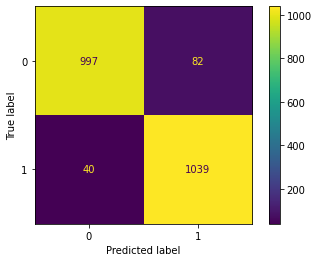

Classification Report : 
               precision    recall  f1-score   support

           0      0.961     0.924     0.942      1079
           1      0.927     0.963     0.945      1079

    accuracy                          0.943      2158
   macro avg      0.944     0.943     0.943      2158
weighted avg      0.944     0.943     0.943      2158



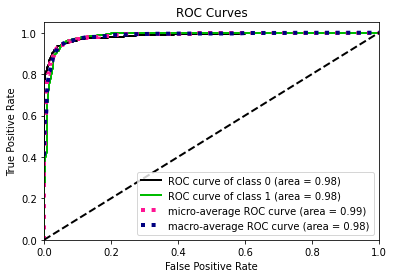

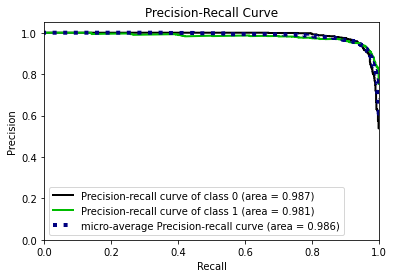

In [59]:
# dan terakhir saya akan mencoba memakai XGBoost Classifer
xgb = XGBClassifier()
# resampling SMOTE
mod.resampling(smote, x, y)
mod.model_fit_eval(xgb)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


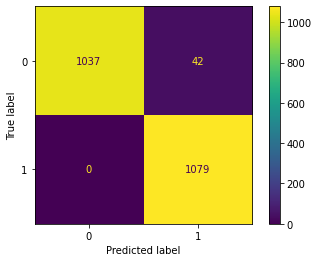

Classification Report : 
               precision    recall  f1-score   support

           0      1.000     0.961     0.980      1079
           1      0.963     1.000     0.981      1079

    accuracy                          0.981      2158
   macro avg      0.981     0.981     0.981      2158
weighted avg      0.981     0.981     0.981      2158



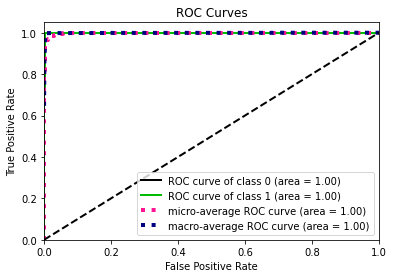

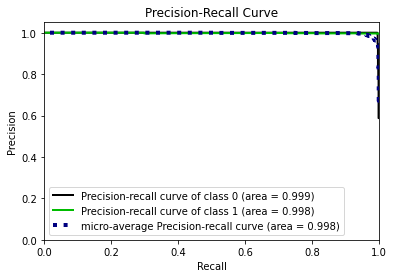

In [60]:
# resampling RandomOverSampler
mod.resampling(rs, x, y)
mod.model_fit_eval(xgb)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


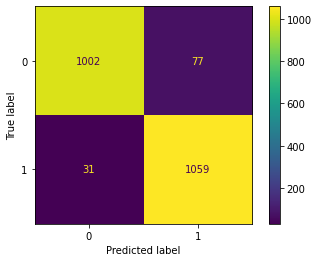

Classification Report : 
               precision    recall  f1-score   support

           0      0.970     0.929     0.949      1079
           1      0.932     0.972     0.951      1090

    accuracy                          0.950      2169
   macro avg      0.951     0.950     0.950      2169
weighted avg      0.951     0.950     0.950      2169



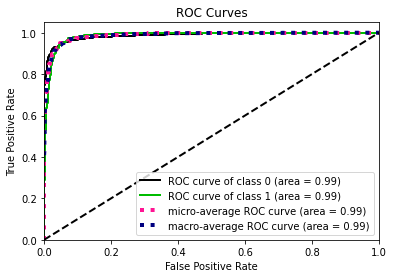

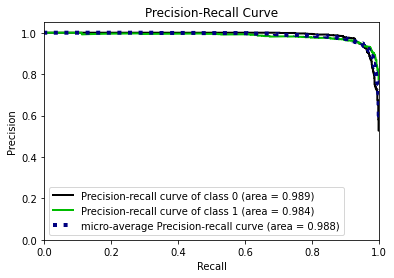

In [61]:
# resampling ADASYN
mod.resampling(ada, x, y)
mod.model_fit_eval(xgb)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


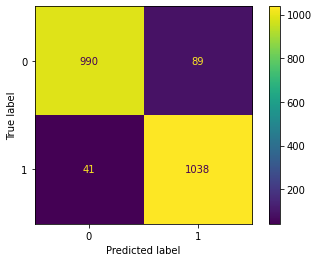

Classification Report : 
               precision    recall  f1-score   support

           0      0.960     0.918     0.938      1079
           1      0.921     0.962     0.941      1079

    accuracy                          0.940      2158
   macro avg      0.941     0.940     0.940      2158
weighted avg      0.941     0.940     0.940      2158



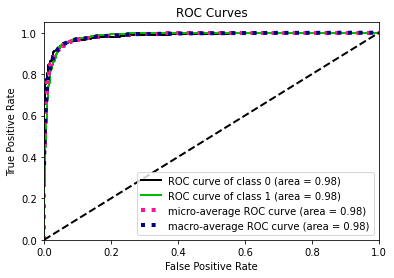

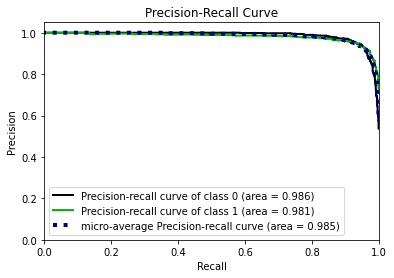

In [62]:
# resampling SMOTENC
mod.resampling(smotenc, x, y)
mod.model_fit_eval(xgb)

Berdasarkan perbandingan model di atas model dengan algoritma Random Forrest dan metode resampling RandomOverSampler adalah yang terbaik dengan nilai f1 score 99,8 %!, dan setelah di evaluasi dengan ROC dan Precission - Recall, kurva menunjukan grafik yang sempurna semua parameter menunjukan nilai 1. dapat ditarik kesimpulan bahwa model ini dapat dengan sempurna membedakan antar 0 class dan 1 class (AUC = 1)

Karena Random Forrest adalah model terbaik untuk dataset ini, saya akan mencoba tuning model dengan algo random forrest dan metode resampling RandomOverSampler yang memiliki f1 score tertinggi dalam model random forrest ini yaitu 99% apakah setelah di tunning performa nya dapat meningkat dari 99 %.

# 4. Model Tunning

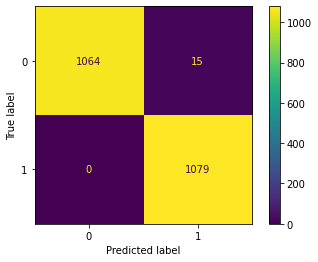

Classification Report : 
               precision    recall  f1-score   support

           0      1.000     0.986     0.993      1079
           1      0.986     1.000     0.993      1079

    accuracy                          0.993      2158
   macro avg      0.993     0.993     0.993      2158
weighted avg      0.993     0.993     0.993      2158



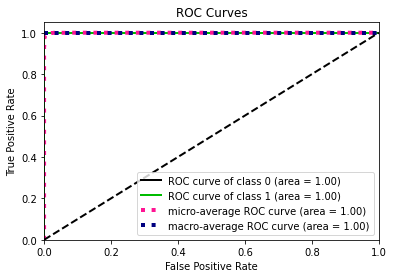

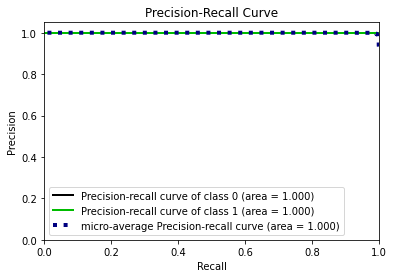

In [63]:
# kita akan mencoba tuning model random forrest dengan metode resampling smotenc
# performa sebelum dilakukan tunning
mod.resampling(rs, x, y)
mod.model_fit_eval(rf)

In [64]:
# karena saya tidak tau hyperparameter apa yang paling berpengaruh pada model ini
# maka saya akan menggunakan randomsearchCV dulu untuk mencari yang paling berpengaruh
# pertama saya akan melihat parameter - parameter default di model ini
from pprint import pprint
print('Parameters Currently in Use : \n')
pprint(rf.get_params())

Parameters Currently in Use : 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [65]:
from sklearn.model_selection import RandomizedSearchCV
# berdasarkan dokumentasi random forrest parameter yang paling berpengaruh adalah seperti di bawah ini:
# jumlah tree pada model
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# jumlah feature pada tiap split
max_features = ['auto', 'sqrt']
# jumlah max level pada tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 6)]
max_depth.append(None)
# minimum jumlah sample yang dibutuhkan untuk split node
min_samples_split = [2, 5, 10]
# Minimum jumlah sample yang dibutuhkan pada tiap leaf node
min_samples_leaf = [1, 2, 4]
# training sample pada tiap tree
bootstrap = [True, False]



In [66]:
# membuat random grid untuk parameter model
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores  
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_rscv = rf_random.fit(mod.x_train, mod.y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [67]:
# berdasarkan randomsearchCV parameter yang terbaik seperti di bawah ini
rf_rscv.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

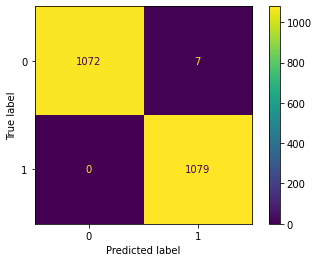

Classification Report : 
               precision    recall  f1-score   support

           0      1.000     0.994     0.997      1079
           1      0.994     1.000     0.997      1079

    accuracy                          0.997      2158
   macro avg      0.997     0.997     0.997      2158
weighted avg      0.997     0.997     0.997      2158



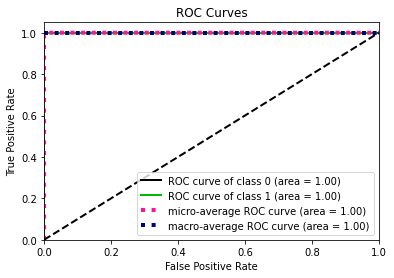

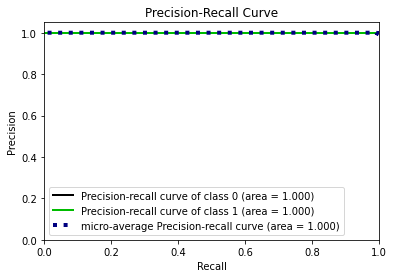

In [70]:
# saya akan memfitting model dengna parameter2 tsb dan evaluasi
clf_rf_rscv = RandomForestClassifier(n_estimators=600,min_samples_leaf=1,min_samples_split=5,max_features='auto',max_depth=40,bootstrap=False)
mod.model_fit_eval(clf_rf_rscv)

terdapat peningkatan performa pada model kita di precision class 1 sebesar 1 %, recall class 0 dan f1 score class 0 sebesar 1 %. Sekarang model kita telah sempurna dimana f1 score meningkat menjadi 100 % WOW!, karena score f1 sudah maksimal 100% pada model tuning ini. maka model ini akan kita gunakan untuk prediksi pada deployment di aplikasi nanti.

# 5. Deployment


In [71]:
# saya akan menyimpan model saya menggunakan pickle agar digunakan untuk deployment nanti
pickle.dump(clf_rf_rscv, open('stoke_predictor.pkl','wb'))

Setelah semua dirasa cukup dan optimal, sekarang waktunya untuk deployment dengan menggunakan Streamlit dan Heroku. Disini saya anya membuat aplikasi sederhana saja. Untuk melihat lebi detail terkait deployment, sila cek di file yang ada di repository atau untuk melihat hasilnya cek di link berikut:

https://

# 6. Conclusion

1. Model terbaik adalah RandomForrest dengan metode resampling RandomOverSampler dengan hasil F-1 Score 100 %!
2. Best Hyperparamter tunning sebagai berikut:
    - 'n_estimators': 200,
    - 'min_samples_split': 2,
    - 'min_samples_leaf': 1,
    - 'max_features': 'sqrt',
    - 'max_depth': 20,
    - 'bootstrap': False
2. Variabel yang relefan atau berpengaruh terhadap target, berurutan adalah:
    - Age
    - heart_disease
    - hypertension
    - avg_glucose_level
    - smoking_status
    - bmi
    - ever_married
    - gender
    - work_type
    - residence_type
3. Perlu adanya seoarang yang memeiliki backgroung ataupun domain expertise pada bidang Kesehatan/Kedokteran karena penentuan treshold pada model tunning sangat mempengaruhi benar tidak nya prediksi 